<a href="https://colab.research.google.com/github/PolinaBoeva/FlightSatisfactionPrediction/blob/main/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

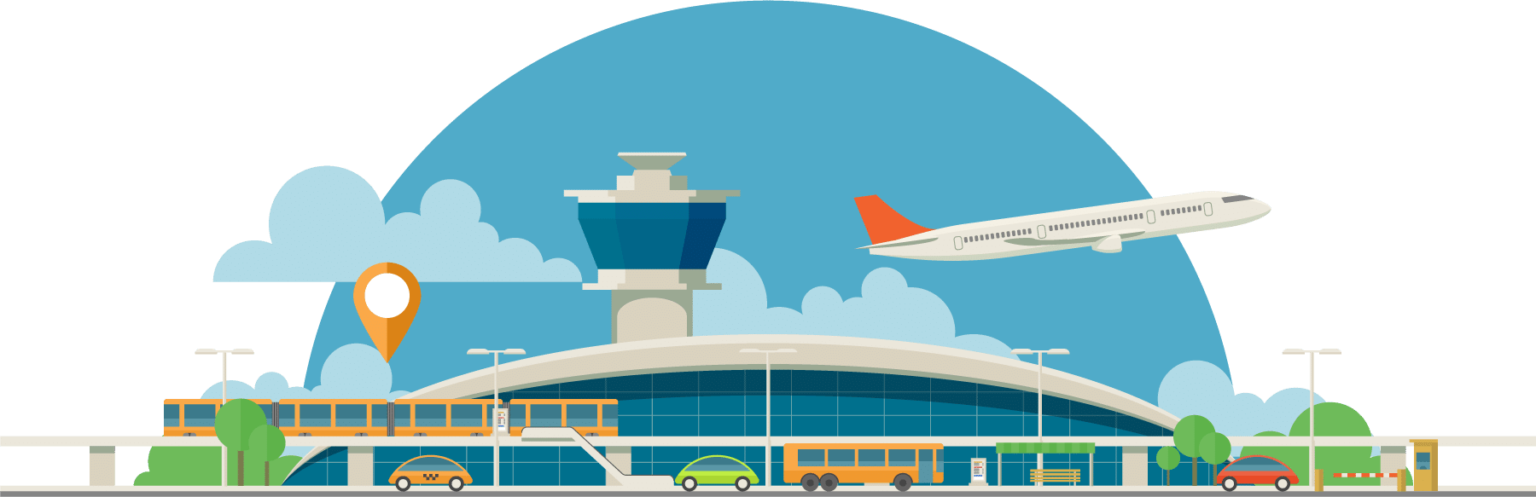

In [ ]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-01-24 07:31:16--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-01-24 07:31:17 (1.37 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

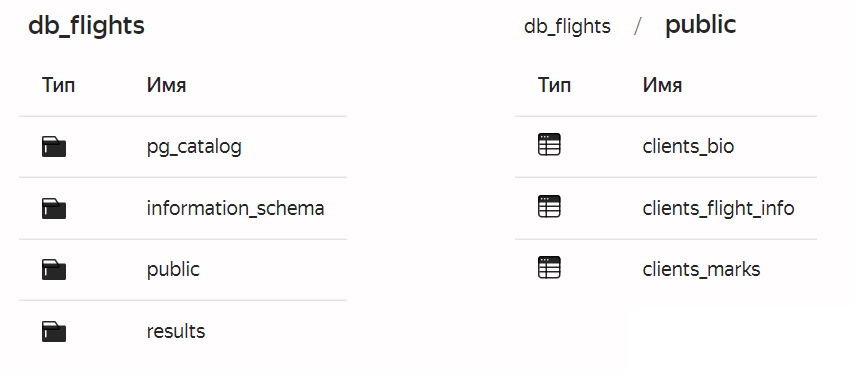



In [ ]:
# Использовала код: https://stackoverflow.com/questions/10598002/how-do-i-get-tables-in-postgres-using-psycopg2
import psycopg2
from psycopg2 import sql

host = "rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net"
port = 6432
dbname = "db_flights"
user = "mlhs_student"
password = "mlhs_student"
sslmode = "verify-full"
target_session_attrs = "read-write"

conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password,
    sslmode=sslmode,
    target_session_attrs=target_session_attrs
)

cursor = conn.cursor()

cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")

tables = cursor.fetchall()

for table in tables:
    print(table[0])

for table in tables:
    table_name = table[0]
    cursor.execute(sql.SQL("""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'public' AND table_name = %s
    """), [table_name])

    columns = cursor.fetchall()
    print(f"\nСтолбцы таблицы {table_name}:")
    for column in columns:
        print(column[0])

cursor.close()
conn.close()

clients_bio
clients_flight_info
clients_marks
results.student_predictions
student_predictions

Столбцы таблицы clients_bio:
id
gender
age

Столбцы таблицы clients_flight_info:
id
Customer Type
Type of Travel
class
Flight Distance
Departure Delay in Minutes
Arrival Delay in Minutes

Столбцы таблицы clients_marks:
id
Inflight wifi service
Departure/Arrival time convenient
Ease of Online booking
Gate location
Food and drink
Online boarding
Seat comfort
Inflight entertainment
On-board service
Leg room service
Baggage handling
Checkin service
Inflight service
cleanliness
satisfaction

Столбцы таблицы results.student_predictions:
surname
id
prediction

Столбцы таблицы student_predictions:
index
id
prediction
surname


In [ ]:
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password,
    sslmode=sslmode,
    target_session_attrs=target_session_attrs
)


query = """
SELECT
    b.id AS bio_id,
    b.gender,
    b.age,
    f."Customer Type",
    f."Type of Travel",
    f.class,
    f."Flight Distance",
    f."Departure Delay in Minutes",
    f."Arrival Delay in Minutes",
    m."Inflight wifi service",
    m."Departure/Arrival time convenient",
    m."Ease of Online booking",
    m."Gate location",
    m."Food and drink",
    m."Online boarding",
    m."Seat comfort",
    m."Inflight entertainment",
    m."On-board service",
    m."Leg room service",
    m."Baggage handling",
    m."Checkin service",
    m."Inflight service",
    m.cleanliness,
    m.satisfaction
FROM
    clients_bio b
JOIN
    clients_flight_info f ON b.id = f.id
JOIN
    clients_marks m ON b.id = m.id
"""

df = pd.read_sql(query, conn)

df.set_index('bio_id', inplace=True)

conn.close()

<ipython-input-14-52a8f4d3ef76>:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
df.head()

gender   age      Customer Type   Type of Travel     class  \
bio_id                                                               
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   

       Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
bio_id                                                                       
7               1963.0                        0.0                      0.0   
13               453.0                       16.0                     30.0   
18               821.0                        0.0                      0.0   
31               212.0                        0.0                      0.0   
39                67.0                        0.0                      0.0   

       Inflight wifi service Departure/Arrival time convenient  ...  \
bio_id                                                          ...   
7                        3.0                               3.0  ...   
13                       2.0                               2.0  ...   
18                       2.0                               5.0  ...   
31                       2.0                               2.0  ...   
39                       3.0                               3.0  ...   

       Online boarding Seat comfort Inflight entertainment On-board service  \
bio_id                                                                        
7                  4.0          5.0                    5.0              5.0   
13                 2.0          5.0                    5.0              2.0   
18                 1.0          5.0                    5.0              5.0   
31                 2.0          2.0                    2.0              4.0   
39                 5.0          4.0                    4.0              4.0   

       Leg room service Baggage handling Checkin service Inflight service  \
bio_id                                                                      
7                   5.0              5.0             4.0              5.0   
13                  4.0              4.0             2.0              4.0   
18                  2.0              5.0             5.0              5.0   
31                  5.0              5.0             5.0              4.0   
39                  4.0              4.0             5.0              4.0   

       cleanliness             satisfaction  
bio_id                                       
7              4.0                satisfied  
13             5.0  neutral or dissatisfied  
18             1.0  neutral or dissatisfied  
31             2.0  neutral or dissatisfied  
39             5.0                satisfied  

[5 rows x 23 columns]

In [ ]:
assert df.shape == (129_549, 23)

In [ ]:
df.to_csv('ml_hw4.csv')

In [ ]:
df = pd.read_csv('D:\Рабочий стол\ml\hw4\mlenv\ml_hw4.csv', index_col='bio_id')
df = df.reset_index(drop=True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [ ]:
df.head()

gender   age      Customer Type   Type of Travel     class  \
0    Male  43.0     Loyal Customer  Business travel  Business   
1    Male  24.0  disloyal Customer  Business travel       Eco   
2  Female  61.0     Loyal Customer  Personal Travel       Eco   
3    Male  35.0  disloyal Customer  Business travel  Business   
4  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0           1963.0                         0.0                       0.0   
1            453.0                        16.0                      30.0   
2            821.0                         0.0                       0.0   
3            212.0                         0.0                       0.0   
4             67.0                         0.0                       0.0   

   Inflight wifi service  Departure/Arrival time convenient  ...  \
0                    3.0                                3.0  ...   
1                    2.0                                2.0  ...   
2                    2.0                                5.0  ...   
3                    2.0                                2.0  ...   
4                    3.0                                3.0  ...   

   Online boarding  Seat comfort  Inflight entertainment  On-board service  \
0              4.0           5.0                     5.0               5.0   
1              2.0           5.0                     5.0               2.0   
2              1.0           5.0                     5.0               5.0   
3              2.0           2.0                     2.0               4.0   
4              5.0           4.0                     4.0               4.0   

   Leg room service  Baggage handling  Checkin service  Inflight service  \
0               5.0               5.0              4.0               5.0   
1               4.0               4.0              2.0               4.0   
2               2.0               5.0              5.0               5.0   
3               5.0               5.0              5.0               4.0   
4               4.0               4.0              5.0               4.0   

   cleanliness             satisfaction  
0          4.0                satisfied  
1          5.0  neutral or dissatisfied  
2          1.0  neutral or dissatisfied  
3          2.0  neutral or dissatisfied  
4          5.0                satisfied  

[5 rows x 23 columns]

In [ ]:
# все изначально в float64
df.info()

# # Список столбцов, которые нужно преобразовать в float
# columns_to_convert = ['age', 'Flight Distance', 'Departure Delay in Minutes',
#        'Arrival Delay in Minutes', 'Inflight wifi service',
#        'Departure/Arrival time convenient', 'Ease of Online booking',
#        'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
#        'Inflight entertainment', 'On-board service', 'Leg room service',
#        'Baggage handling', 'Checkin service', 'Inflight service',
#        'cleanliness']

# df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129549 entries, 0 to 129548
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      1295

In [ ]:
df.select_dtypes('float').columns

Index(['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness'],
      dtype='object')

In [ ]:
# пропуски есть во многих столбцах, в том числе и в катгориальных признаках
df.isna().sum()

gender                                 0
age                                  315
Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

In [ ]:
# Пропуски в столбце satisfaction отмечены как -
df['satisfaction'].unique()

array(['satisfied', 'neutral or dissatisfied', '-'], dtype=object)

In [ ]:
# 25905 пропусков в столбце satisfaction
df[df['satisfaction'] == '-'].shape

(25905, 23)

In [ ]:
# посмотрим выбросы. Выбросы для числовых буду считать через Q1+−1.5×IQR
def count_data_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))].shape[0]

In [ ]:
# большое количество выбросов в столбце Departure Delay in Minutes и Arrival Delay in Minutes, а также в Checkin service
number_columns = df.select_dtypes('float').columns
for col in number_columns:
    print(f'Выбросов в столбце {col}: {count_data_outliers(df[col])}')

Выбросов в столбце age: 448
Выбросов в столбце Flight Distance: 3074
Выбросов в столбце Departure Delay in Minutes: 18124
Выбросов в столбце Arrival Delay in Minutes: 17499
Выбросов в столбце Inflight wifi service: 24
Выбросов в столбце Departure/Arrival time convenient: 35
Выбросов в столбце Ease of Online booking: 29
Выбросов в столбце Gate location: 39
Выбросов в столбце Food and drink: 28
Выбросов в столбце Online boarding: 32
Выбросов в столбце Seat comfort: 34
Выбросов в столбце Inflight entertainment: 23
Выбросов в столбце On-board service: 26
Выбросов в столбце Leg room service: 39
Выбросов в столбце Baggage handling: 27
Выбросов в столбце Checkin service: 16103
Выбросов в столбце Inflight service: 39
Выбросов в столбце cleanliness: 25


In [ ]:
cat_columns = df.select_dtypes('object').columns
for col in cat_columns:
    print(df[col].value_counts())

gender
Female    65726
Male      63823
Name: count, dtype: int64
Customer Type
Loyal Customer       105763
disloyal Customer     23709
Name: count, dtype: int64
Type of Travel
Business travel    89405
Personal Travel    40043
Name: count, dtype: int64
class
Business    61939
Eco         58115
Eco Plus     9379
Name: count, dtype: int64
satisfaction
neutral or dissatisfied    58732
satisfied                  44912
-                          25905
Name: count, dtype: int64


### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Figure size 1000x600 with 0 Axes>

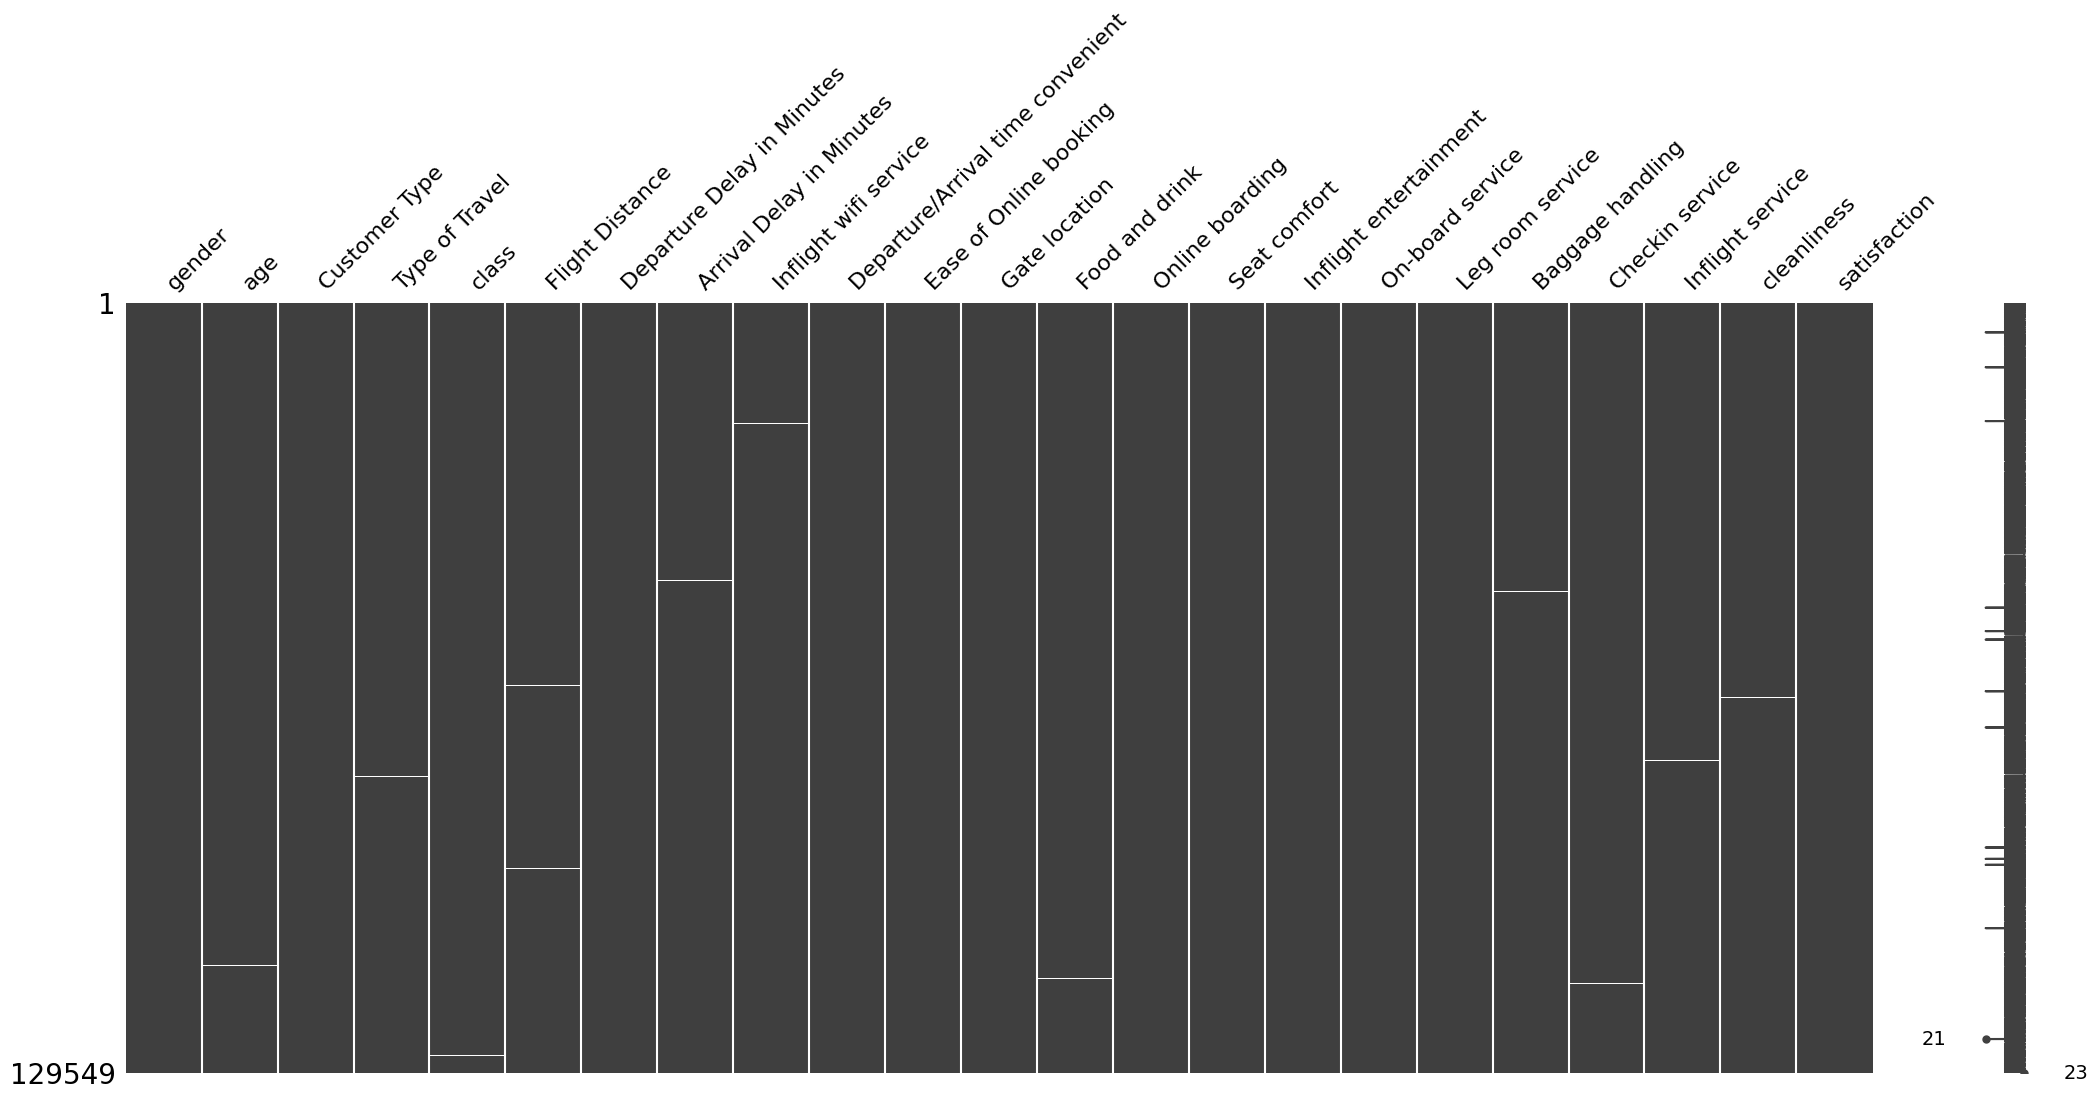

In [ ]:
plt.figure(figsize=(10, 6))
missingno.matrix(df)
plt.show()

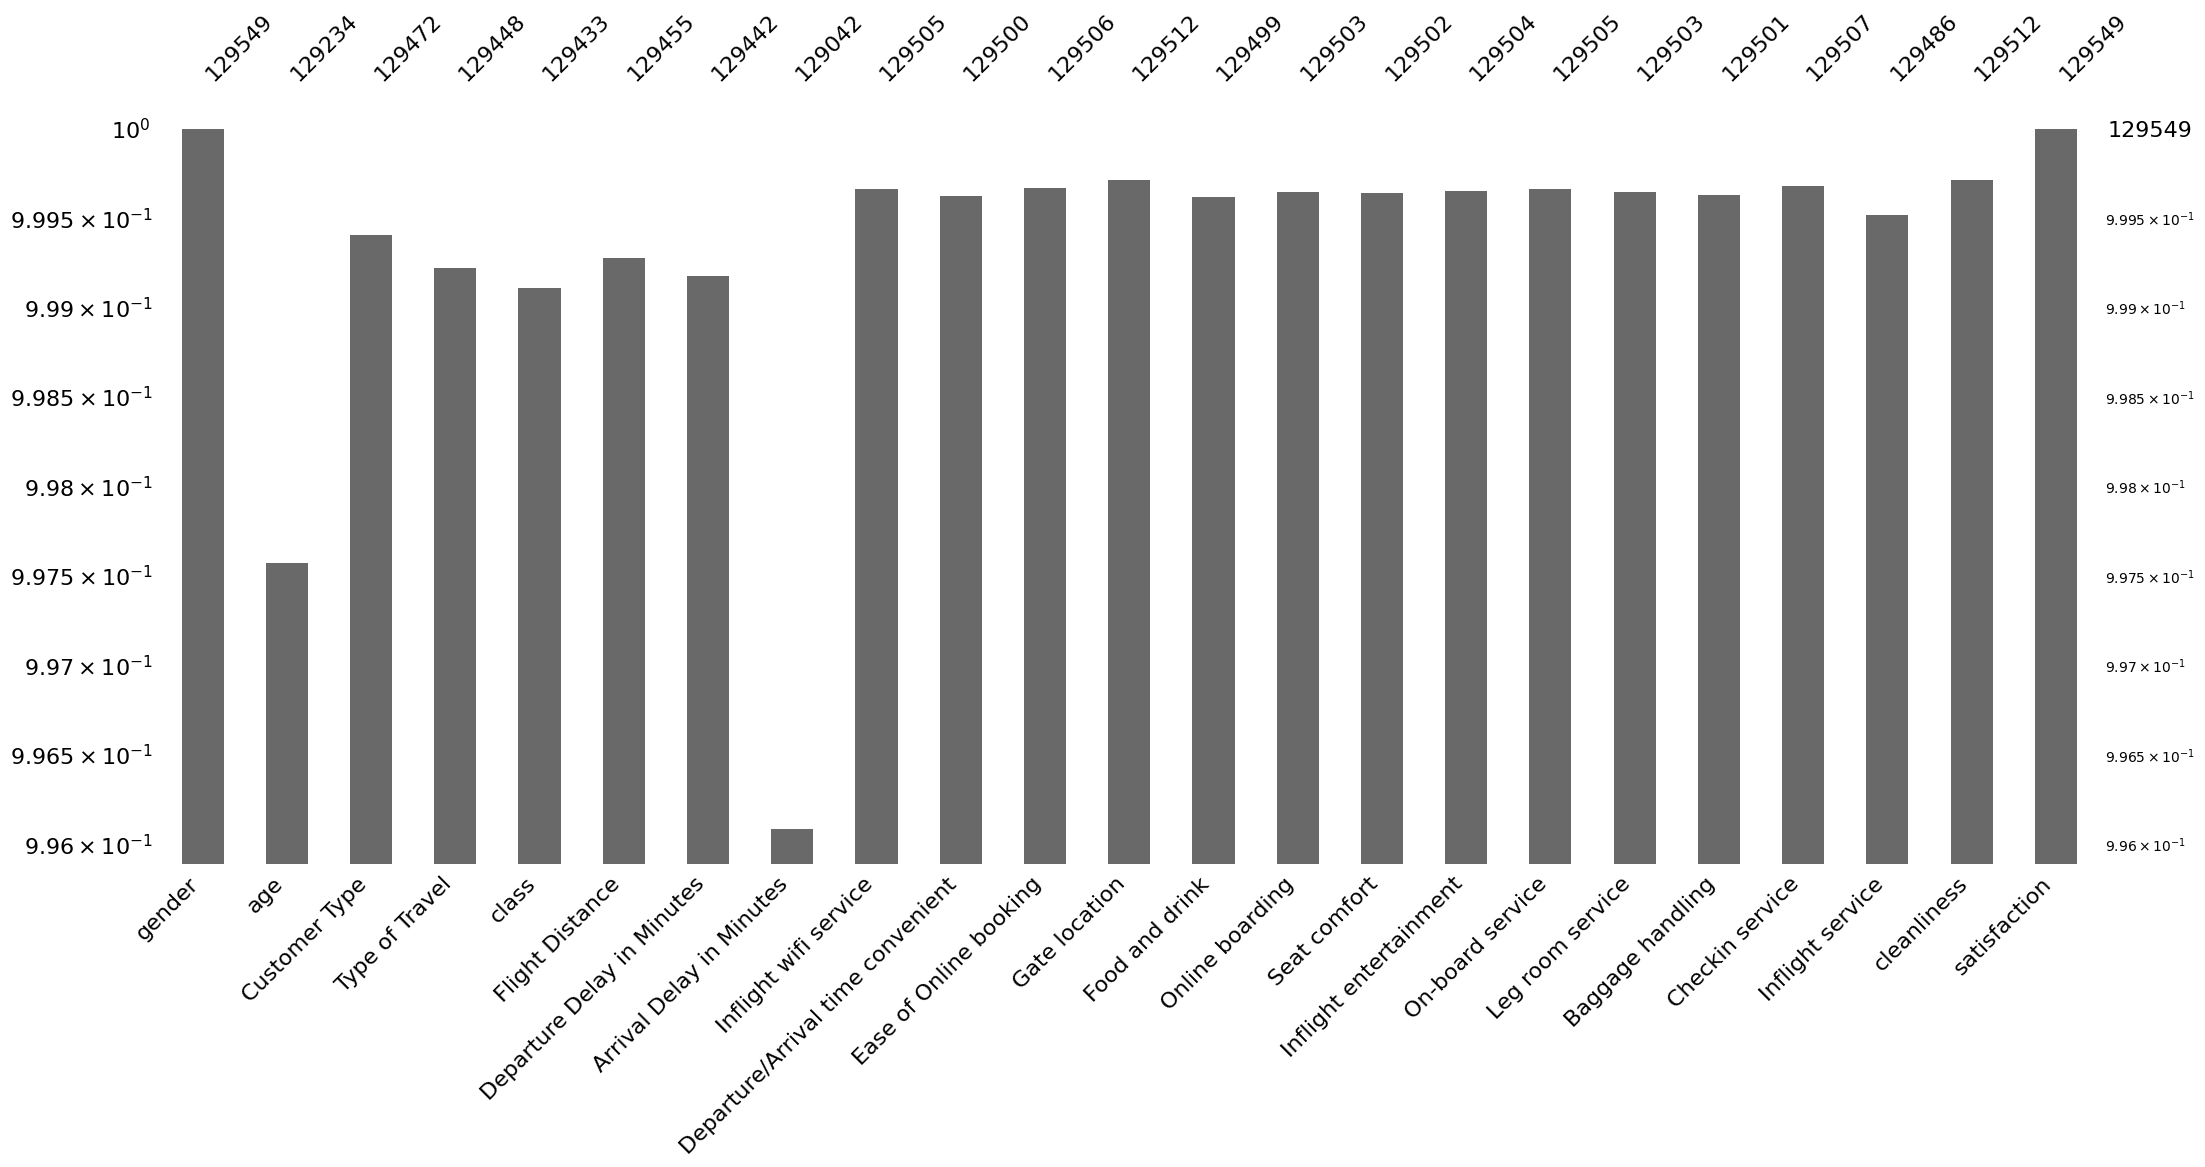

In [ ]:
plt.figure(figsize=(10, 6))
missingno.bar(df, log=True)
plt.show()

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [ ]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
0         Male  43.0     Loyal Customer  Business travel  Business   
1         Male  24.0  disloyal Customer  Business travel       Eco   
2       Female  61.0     Loyal Customer  Personal Travel       Eco   
3         Male  35.0  disloyal Customer  Business travel  Business   
4       Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129542  Female  28.0     Loyal Customer  Personal Travel       Eco   
129543    Male  66.0     Loyal Customer  Personal Travel       Eco   
129544  Female  59.0     Loyal Customer  Personal Travel       Eco   
129545    Male  61.0     Loyal Customer  Personal Travel       Eco   
129546    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                1963.0                         0.0                       0.0   
1                 453.0                        16.0                      30.0   
2                 821.0                         0.0                       0.0   
3                 212.0                         0.0                       0.0   
4                  67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129542            447.0                        23.0                      16.0   
129543            337.0                       199.0                     213.0   
129544            308.0                        32.0                      24.0   
129545            337.0                         0.0                       0.0   
129546            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
0                         3.0                                3.0  ...   
1                         2.0                                2.0  ...   
2                         2.0                                5.0  ...   
3                         2.0                                2.0  ...   
4                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129542                    1.0                                3.0  ...   
129543                    2.0                                4.0  ...   
129544                    3.0                                5.0  ...   
129545                    2.0                                4.0  ...   
129546                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
0                   4.0           5.0                     5.0   
1                   2.0           5.0                     5.0   
2                   1.0           5.0                     5.0   
3                   2.0           2.0                     2.0   
4                   5.0           4.0                     4.0   
...                 ...           ...                     ...   
129542              1.0           3.0                     3.0   
129543              5.0           5.0                     5.0   
129544              5.0           5.0                     3.0   
129545              2.0           3.0                     3.0   
129546              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                    5.0               5.0               5.0              4.0   
1                    2.0               4.0               4.0              2.0   
2                    5.0               2.0               5.0              5.0   
3                    4.0               5.0               5.0              5.0   
4                    4.0               4.0               4.0              5.0   
...                  ...               ...        

In [ ]:
assert df_train.shape == (103_644, 23)

In [ ]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
5         Male  36.0  Loyal Customer  Business travel  Business   
7       Female  70.0  Loyal Customer  Personal Travel       Eco   
12        Male  66.0  Loyal Customer  Personal Travel       Eco   
19      Female  60.0  Loyal Customer  Business travel  Business   
24        Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129531    Male  38.0  Loyal Customer  Business travel       Eco   
129535    Male  16.0  Loyal Customer  Personal Travel       Eco   
129539  Female  43.0  Loyal Customer  Personal Travel       Eco   
129547    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129548    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
5                3655.0                        40.0                      71.0   
7                 108.0                        50.0                      41.0   
12                562.0                        88.0                      84.0   
19               3756.0                        36.0                      24.0   
24                802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129531            337.0                        92.0                      82.0   
129535            308.0                         2.0                       0.0   
129539            308.0                         0.0                       0.0   
129547            447.0                         0.0                       0.0   
129548            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
5                         1.0                                1.0  ...   
7                         5.0                                4.0  ...   
12                        2.0                                5.0  ...   
19                        4.0                                4.0  ...   
24                        1.0                                2.0  ...   
...                       ...                                ...  ...   
129531                    4.0                                3.0  ...   
129535                    3.0                                4.0  ...   
129539                    2.0                                4.0  ...   
129547                    3.0                                4.0  ...   
129548                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
5                  1.0              3.0           3.0                     3.0   
7                  4.0              4.0           4.0                     3.0   
12                 5.0              2.0           5.0                     5.0   
19                 2.0              4.0           5.0                     4.0   
24                 2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129531             4.0              5.0           4.0                     4.0   
129535             1.0              3.0           5.0                     1.0   
129539             3.0              5.0           5.0                     4.0   
129547             4.0              3.0           4.0                     4.0   
129548             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
5                    3.0               3.0               1.0              4.0   
7                    3.0               0.0               3.0              5.0   
12                   3.0               5.0               2.0              5.0   
19                   4.0               4.0              

In [ ]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [ ]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [ ]:
for column in X_train.columns:
    mode_value = X_train[column].mode()[0]
    X_train[column] = X_train[column].fillna(mode_value)
    X_val[column] = X_val[column].fillna(mode_value)
    df_test[column] = df_test[column].fillna(mode_value)

In [ ]:
X_val.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [ ]:
# Ваш код ниже
df.describe(include='all')

gender            age   Customer Type   Type of Travel     class  \
count   129549  129234.000000          129472           129448    129433   
unique       2            NaN               2                2         3   
top     Female            NaN  Loyal Customer  Business travel  Business   
freq     65726            NaN          105763            89405     61939   
mean       NaN      40.116951             NaN              NaN       NaN   
std        NaN      20.376129             NaN              NaN       NaN   
min        NaN       0.000000             NaN              NaN       NaN   
25%        NaN      27.000000             NaN              NaN       NaN   
50%        NaN      40.000000             NaN              NaN       NaN   
75%        NaN      51.000000             NaN              NaN       NaN   
max        NaN     621.000000             NaN              NaN       NaN   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count     129455.000000               129442.000000             129042.000000   
unique              NaN                         NaN                       NaN   
top                 NaN                         NaN                       NaN   
freq                NaN                         NaN                       NaN   
mean        1322.922158                   15.809026                 16.656499   
std         4517.816532                   93.276882                109.285072   
min            0.000000                    0.000000                  0.000000   
25%          414.000000                    0.000000                  0.000000   
50%          846.000000                    0.000000                  0.000000   
75%         1744.000000                   12.000000                 13.000000   
max       379620.000000                22227.000000              14006.000000   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
count           129505.000000                      129500.000000  ...   
unique                    NaN                                NaN  ...   
top                       NaN                                NaN  ...   
freq                      NaN                                NaN  ...   
mean                 2.732327                           3.062131  ...   
std                  1.360033                           1.559627  ...   
min                  0.000000                           0.000000  ...   
25%                  2.000000                           2.000000  ...   
50%                  3.000000                           3.000000  ...   
75%                  4.000000                           4.000000  ...   
max                 45.000000                          45.000000  ...   

        Online boarding   Seat comfort  Inflight entertainment  \
count     129503.000000  129502.000000           129504.000000   
unique              NaN            NaN                     NaN   
top                 NaN            NaN                     NaN   
freq                NaN            NaN                     NaN   
mean           3.256782       3.445669                3.361232   
std            1.381888       1.349713                1.366908   
min            0.000000       0.000000                0.000000   
25%            2.000000       2.000000                2.000000   
50%            3.000000       4.000000                4.000000   
75%            4.000000       5.000000                4.000000   
max           40.000000      45.000000               45.000000   

        On-board service  Leg room service  Baggage handling  Checkin service  \
count      129505.000000     129503.000000     129501.000000    129507.000000   
unique               NaN               NaN               NaN              NaN   
top                  NaN               NaN               NaN              NaN   
freq                 NaN               NaN               NaN              NaN   
mean            3.387259          3.355976     

Можно отметить, что в столбце Flight Distance минимальное значение 0, вероятно ошибка, возможно отмененный рейс.

Departure Delay in Minutes и Arrival Delay in Minutes имеют максимальные значения сильно отклоняющиеся от среднего, вероятно выбросы.

Inflight wifi service\Seat comfort\Online boarding\Inflight entertainment\On-board service\Leg room service\Baggage handling\Checkin service\Inflight service cleanliness основная часть оценок расположена в среднем диапазоне (от 2 до 4\5), максимальное значение сильно выбивается, вероятно выбросы.

Среднее значение satisfaction лежит в районе neutral or dissatisfied (нейтральное или неудовлетворительное).


### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [ ]:
# Функция для удаления выбросов
def remove_outliers(X, y):
    for column in X.select_dtypes('float').columns:
        quantile_996 = X[column].quantile(0.996)
        mask = (X[column] <= quantile_996)
        X = X[mask]
        y = y[mask].loc[X.index]
    return X, y

X_train, y_train = remove_outliers(X_train, y_train)
X_val, y_val = remove_outliers(X_val, y_val)

In [ ]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [ ]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [ ]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    rows = (len(cols) // 2) + (len(cols) % 2)  # Определяем количество строк в зависимости от cols, подсмотрела у chat gpt после того как вылезла ошибка IndexError: index 8 is out of bounds for axis 0 with size 8
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.countplot(x=col, data=df, hue=y, ax=axes[i])
        axes[i].set_title(f'{col} distribution')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel(col)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    rows = (len(cols) * 2) // 2 + (len(cols) % 2)  # Мы умножаем количество столбцов на 2, потому что для каждого столбца будет два графика (KDE и boxplot). После этого мы делим на 2, чтобы определить количество строк. Если количество столбцов не делится на 2, мы добавляем одну строку.
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.kdeplot(data=df, x=col, hue=y, ax=axes[2 * i], fill=True)
        axes[2 * i].set_title(f'{col} KDE')
        axes[2 * i].set_xlabel(col)
        axes[2 * i].set_ylabel('Density')

        # График Boxplot на второй оси
        sns.boxplot(data=df, x=col, hue=y, ax=axes[2 * i + 1], palette='Set2')
        axes[2 * i + 1].set_title(f'{col} Boxplot')
        axes[2 * i + 1].set_xlabel(col)
        axes[2 * i + 1].set_ylabel('Value')

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    rows = (len(cols) // 2) + (len(cols) % 2)
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.countplot(x=col, data=df, hue=y, ax=axes[i])
        axes[i].set_title(f'{col} distribution')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel(col)
    plt.tight_layout()
    plt.show()

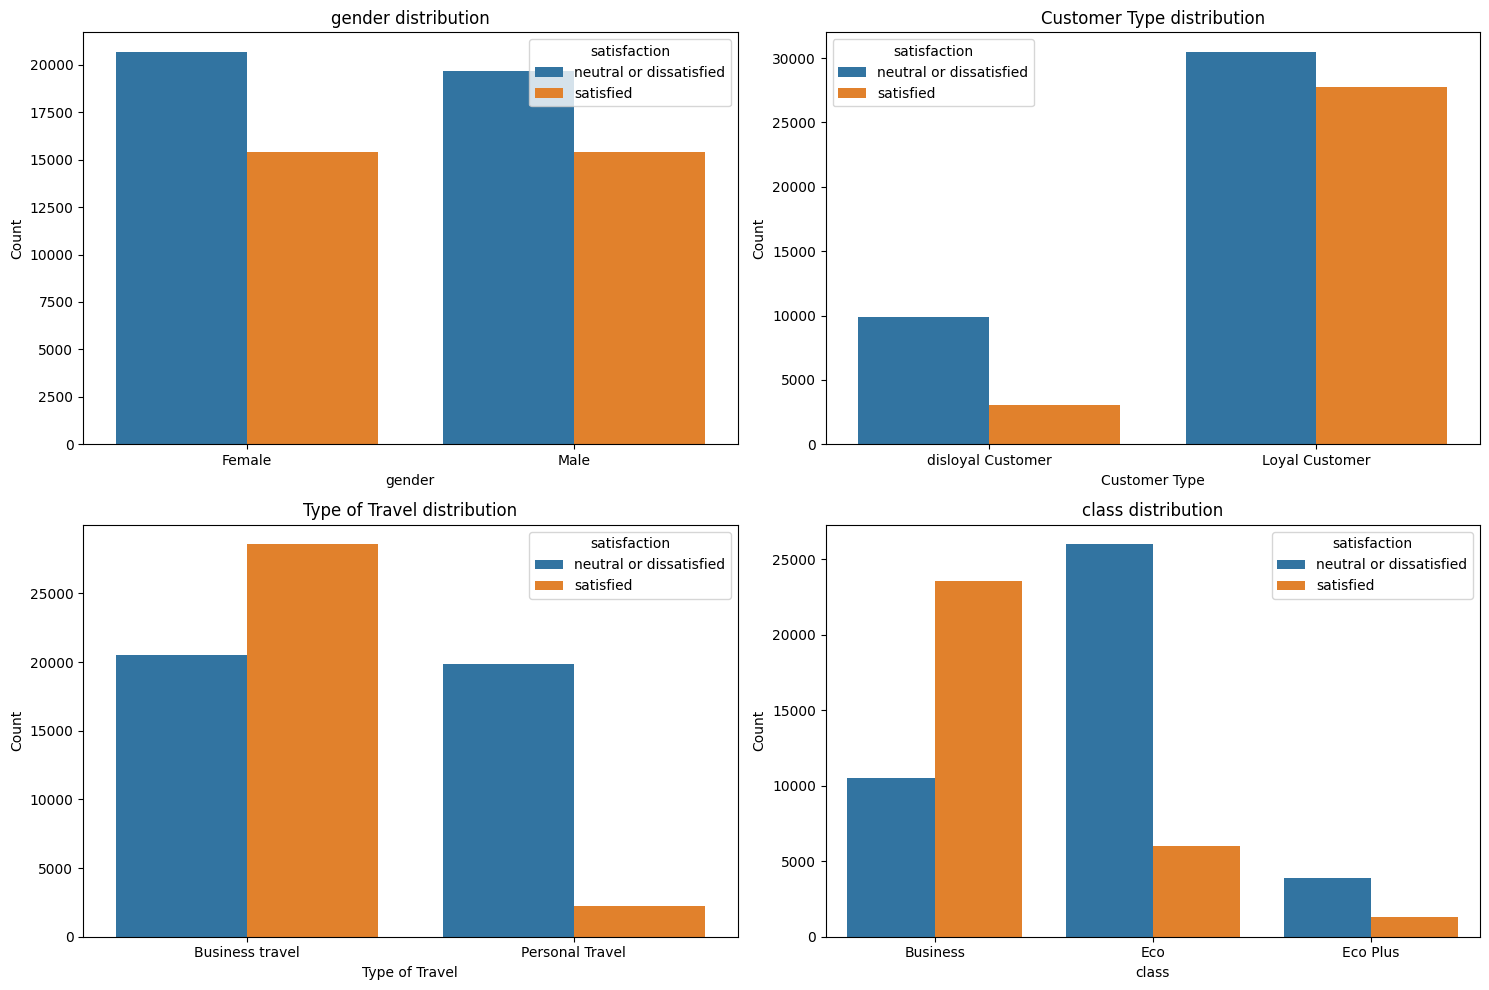

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

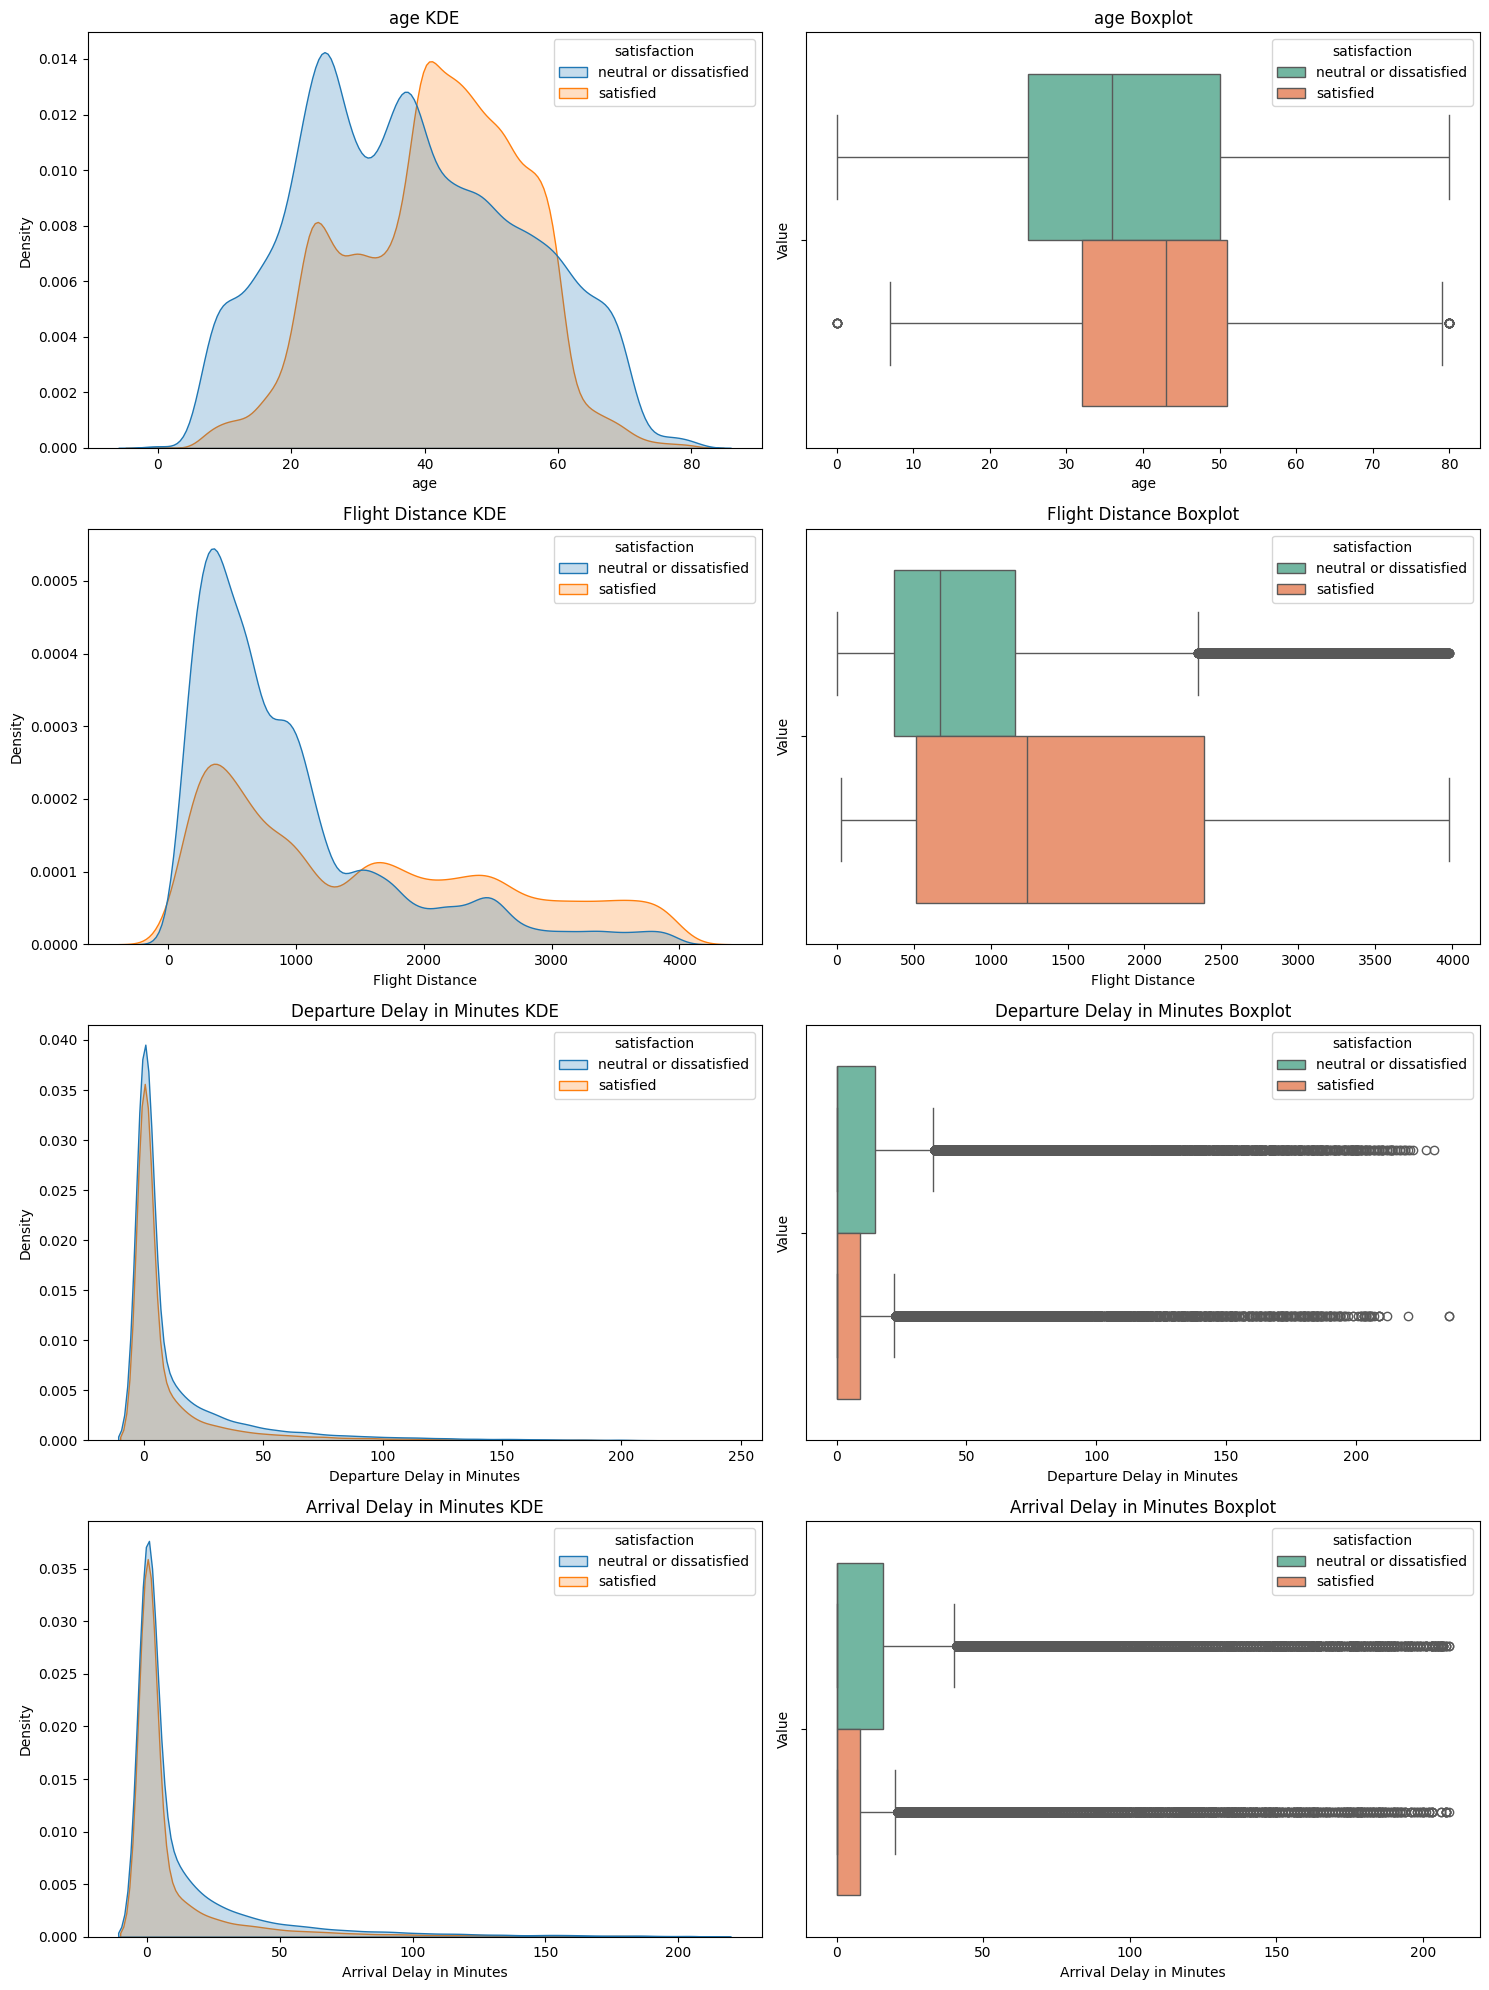

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

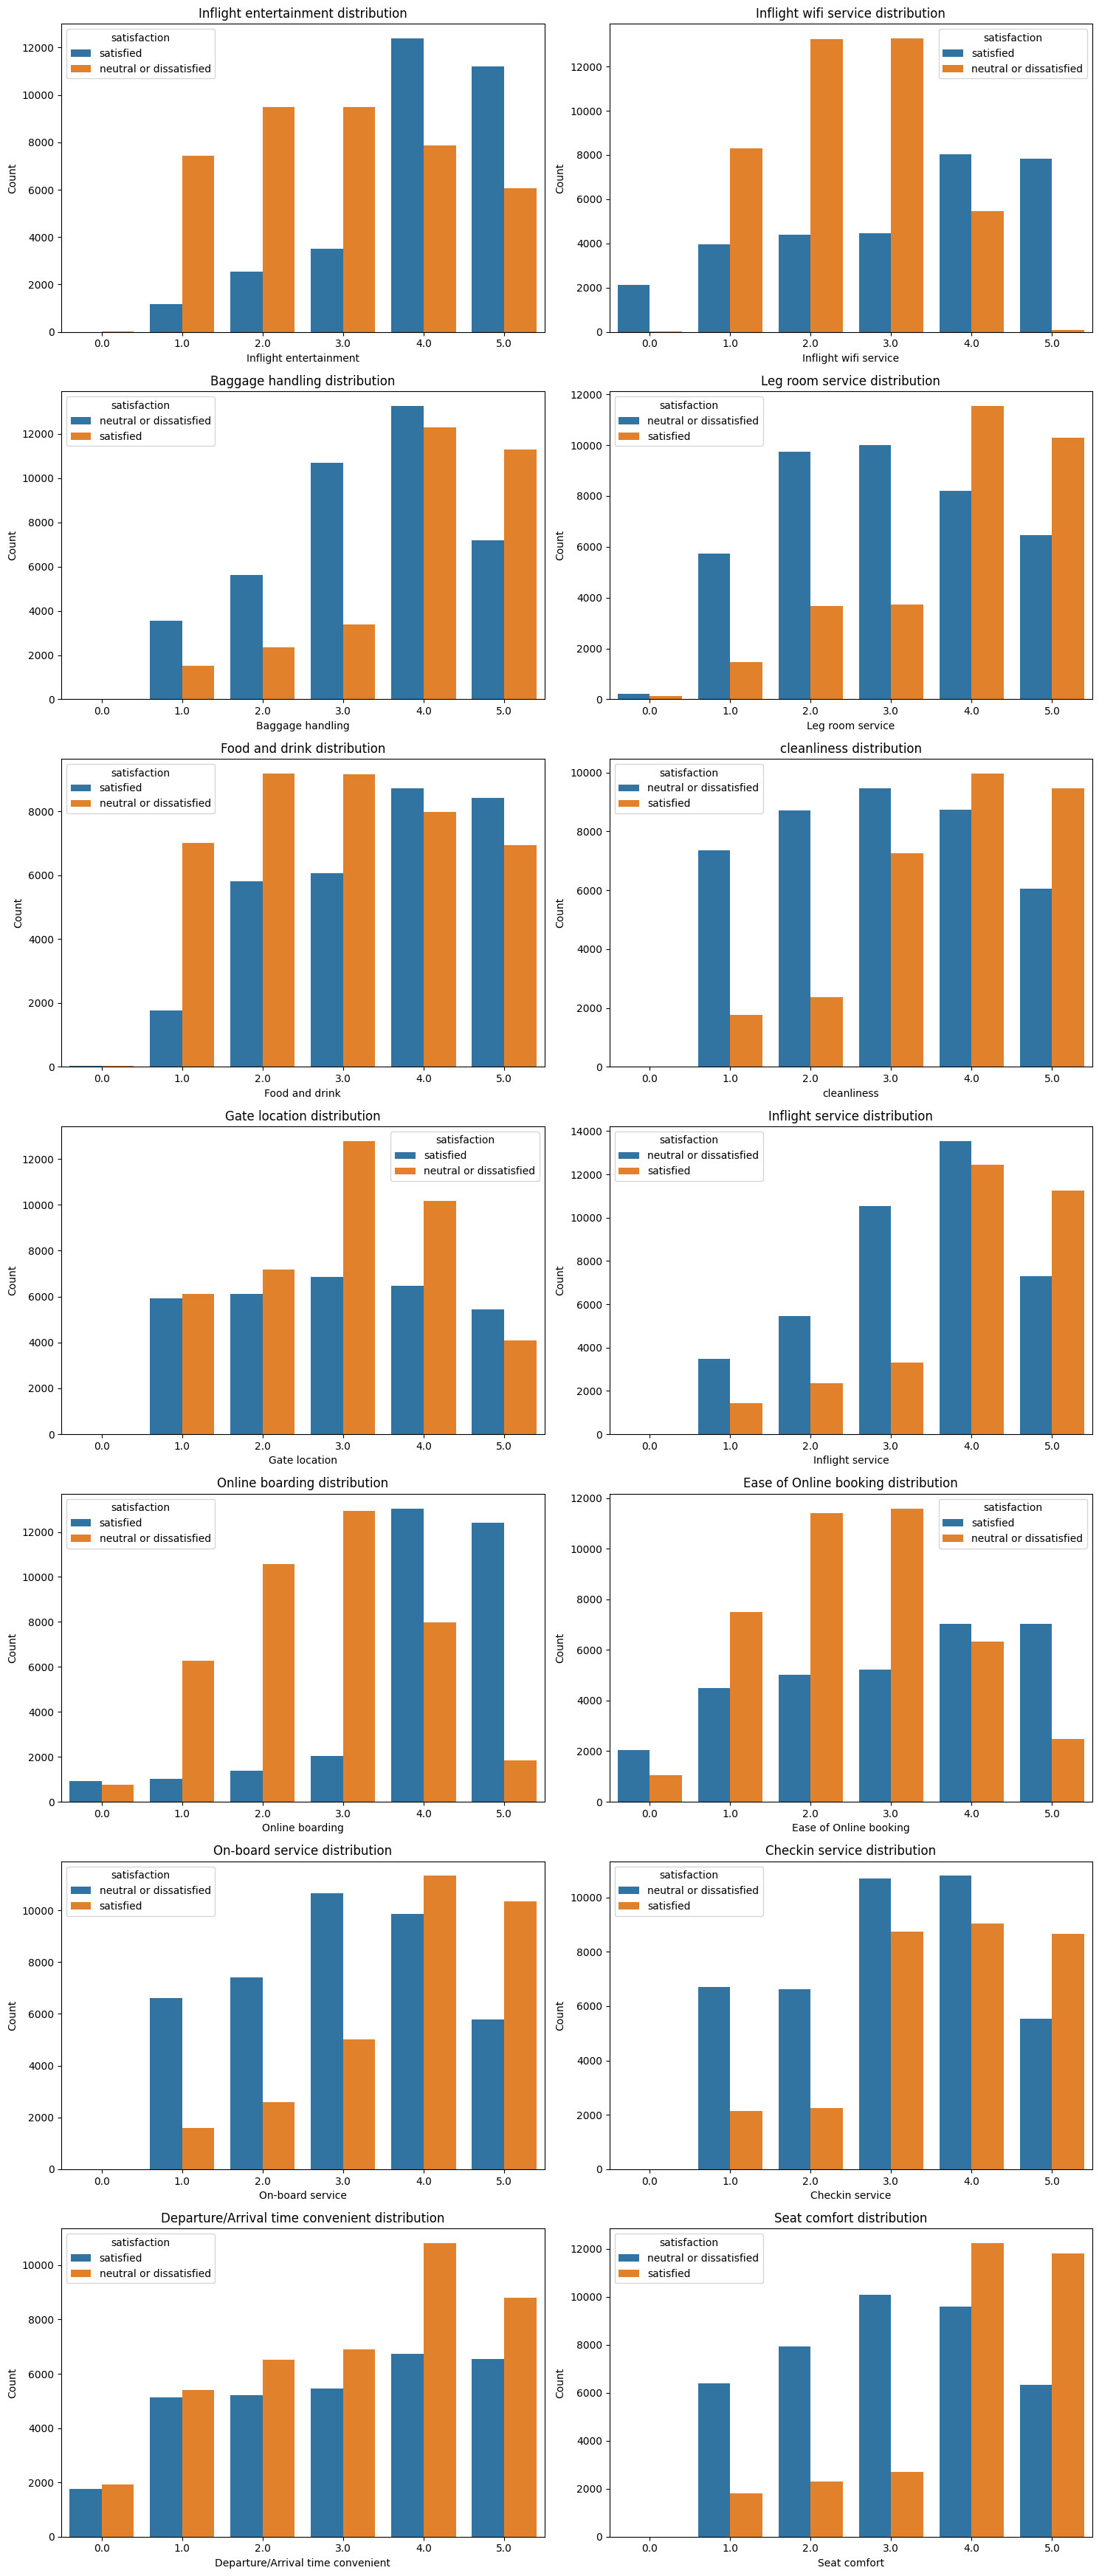

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

In [ ]:
y_train.unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

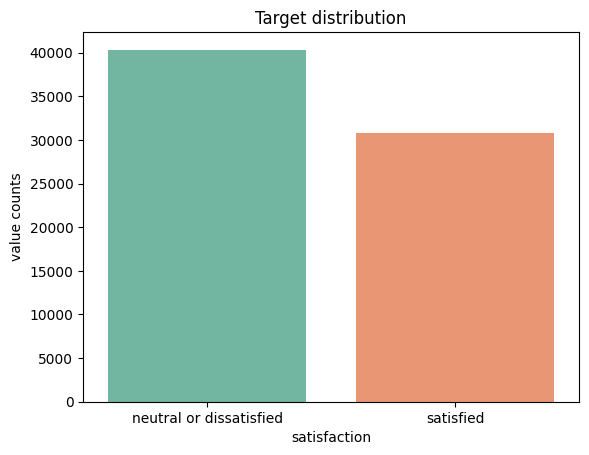

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train, palette='Set2')

plt.title("Target distribution")
plt.xlabel("satisfaction")
plt.ylabel("value counts")
plt.xticks([0, 1], y_train.unique())
plt.show()


### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

• Есть дисбаланс классов в таргете: большиство нейтрально или неудовлитворительно.

• Для континуальных признаков распределение для satisfied и neutral or dassatisfied схоже.

• Большинство распределений континуальных признаков скошенные, у переменных arrival delay и departure delay распределение похоже на логнормальное.


### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

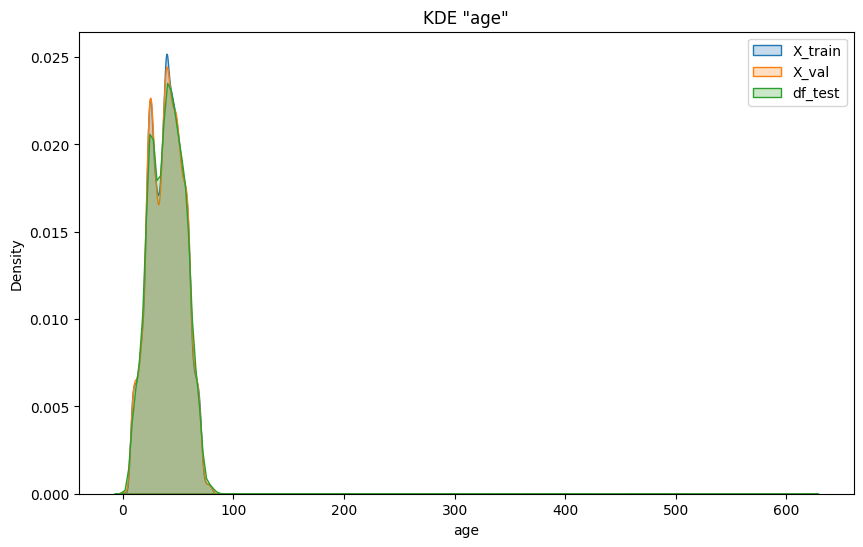

In [ ]:
# визуализация переменной age для тренировочного, валидационного и тестового наборов данных. Можно отметить схожесть распределения переменной в трех наборах данных
age_data = [
    X_train['age'],
    X_val['age'],
    df_test['age']
]

labels = ['X_train', 'X_val', 'df_test']

plt.figure(figsize=(10, 6))
sns.kdeplot(age_data[0], label=labels[0], shade=True)
sns.kdeplot(age_data[1], label=labels[1], shade=True)
sns.kdeplot(age_data[2], label=labels[2], shade=True)

plt.legend()
plt.title('KDE "age"')

plt.show()

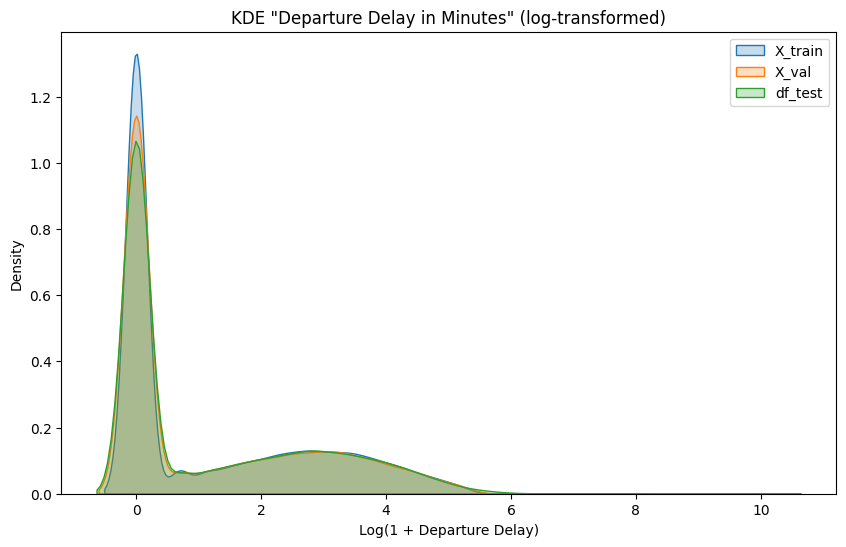

In [ ]:
# Визуализация переменной "Departure Delay in Minutes" для тренировочного, валидационного и тестового наборов данных.
# Можно отметить схожесть распределения переменной в трех наборах данных.
# Переменная была логарифмирована для улучшения визуализации
delay_data = [
    X_train['Departure Delay in Minutes'],
    X_val['Departure Delay in Minutes'],
    df_test['Departure Delay in Minutes']
]

labels = ['X_train', 'X_val', 'df_test']

plt.figure(figsize=(10, 6))

sns.kdeplot(np.log1p(delay_data[0]), label=labels[0], shade=True)
sns.kdeplot(np.log1p(delay_data[1]), label=labels[1], shade=True)
sns.kdeplot(np.log1p(delay_data[2]), label=labels[2], shade=True)

plt.legend()
plt.title('KDE "Departure Delay in Minutes" (log-transformed)')
plt.xlabel('Log(1 + Departure Delay)')
plt.show()

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [ ]:
X_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = X_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].apply(lambda x: np.log(x + 1))
X_val[['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = X_val[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].apply(lambda x: np.log(x + 1))
df_test[['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = df_test[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].apply(lambda x: np.log(x + 1))

Построение.

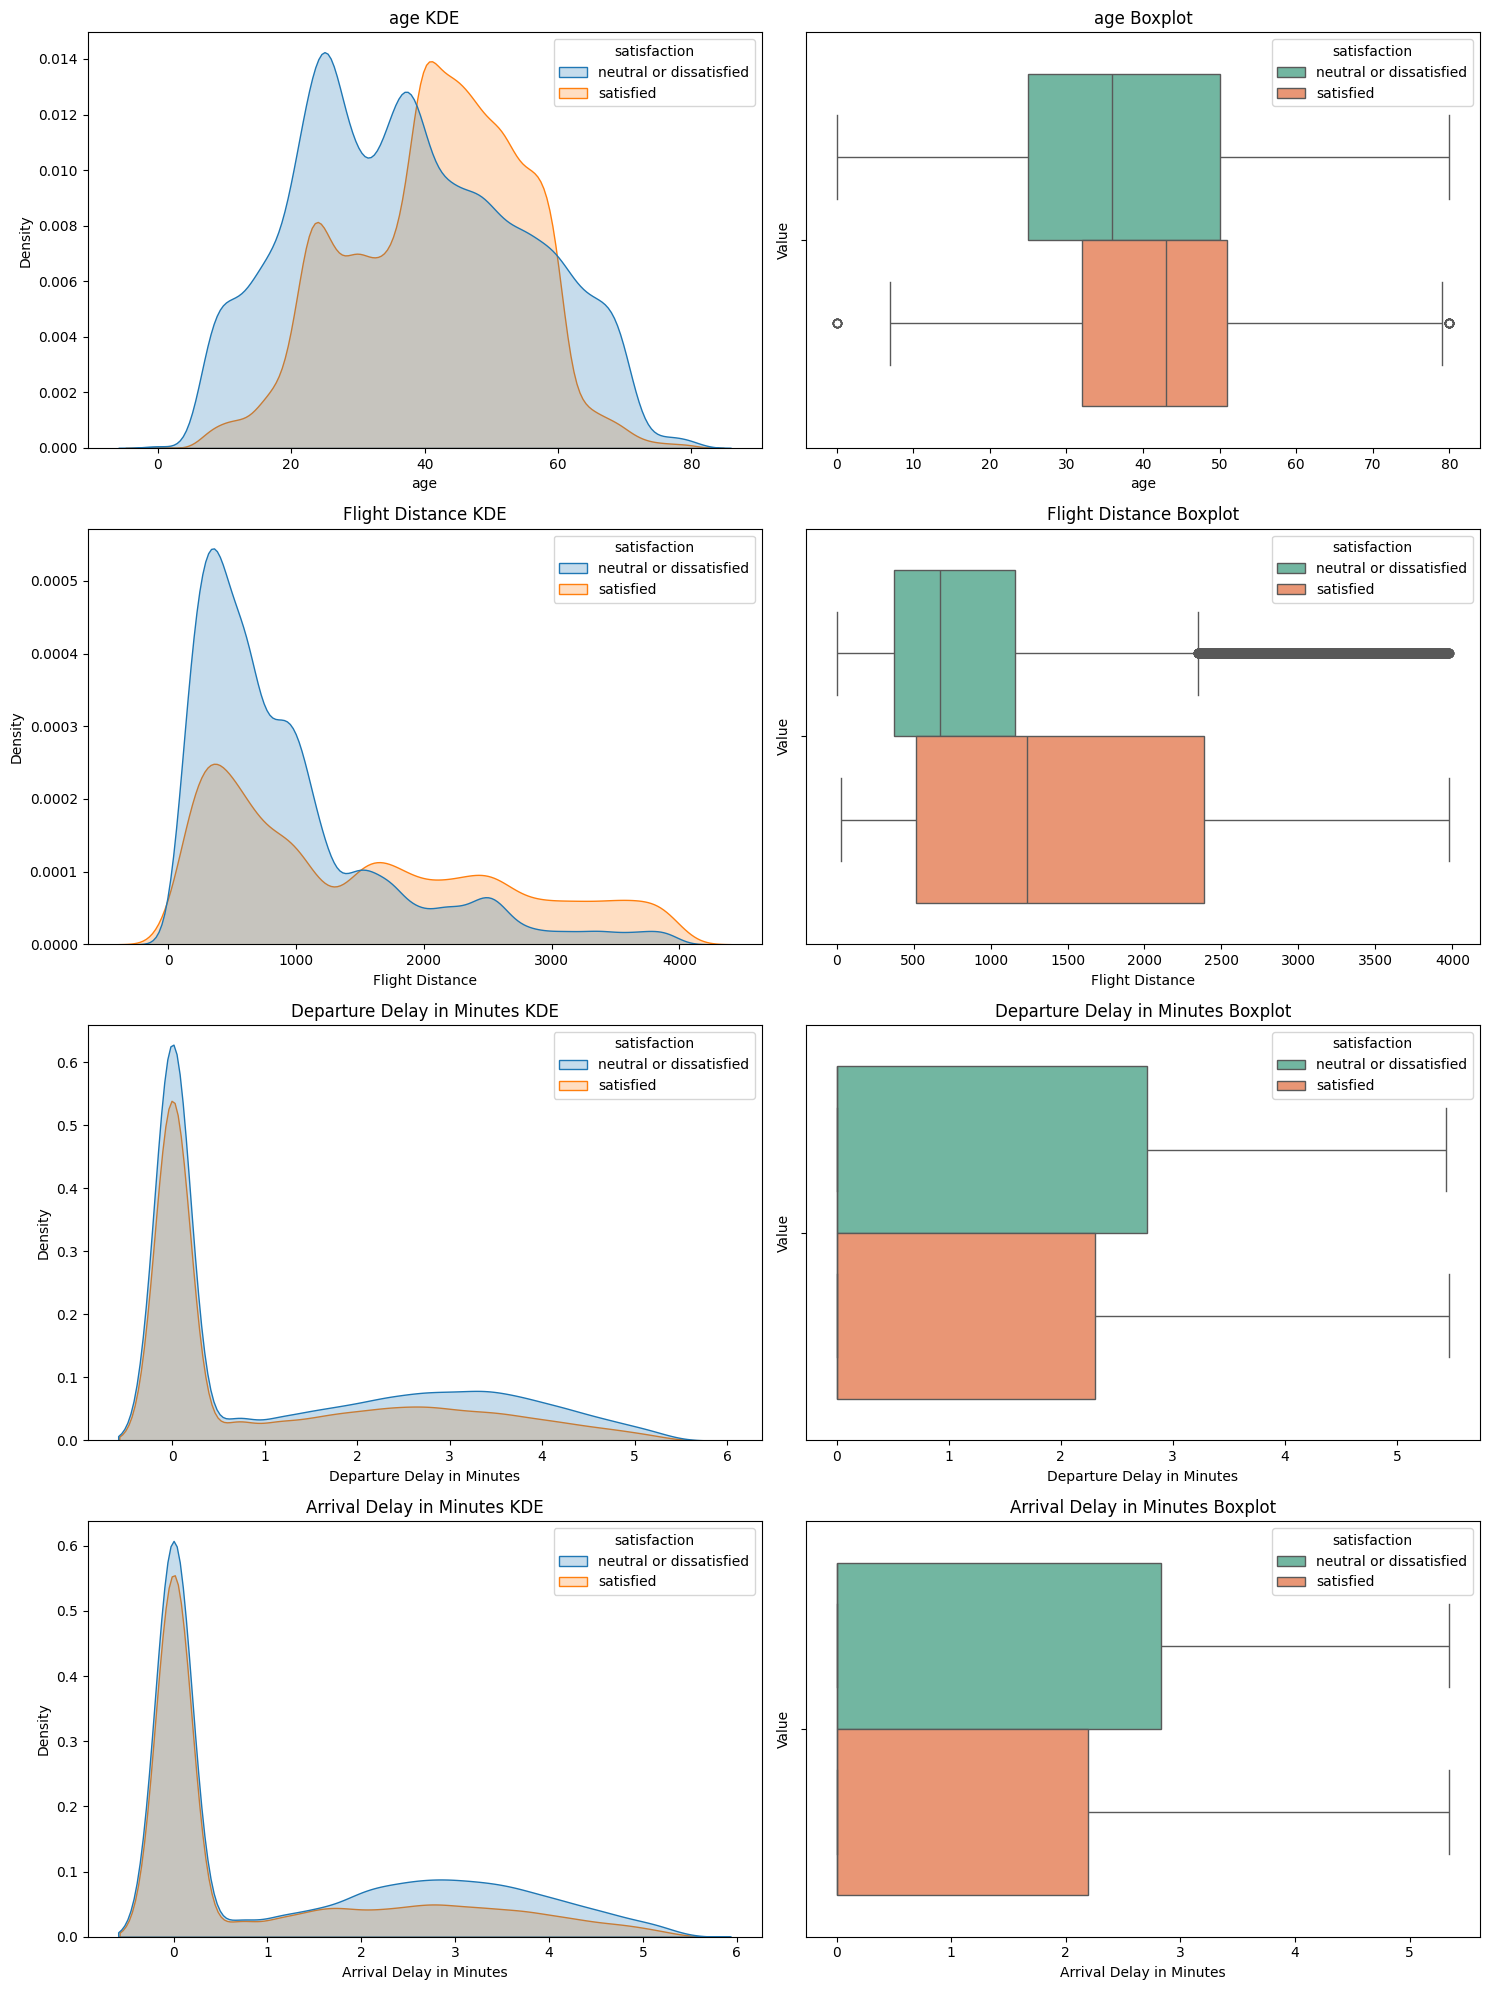

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

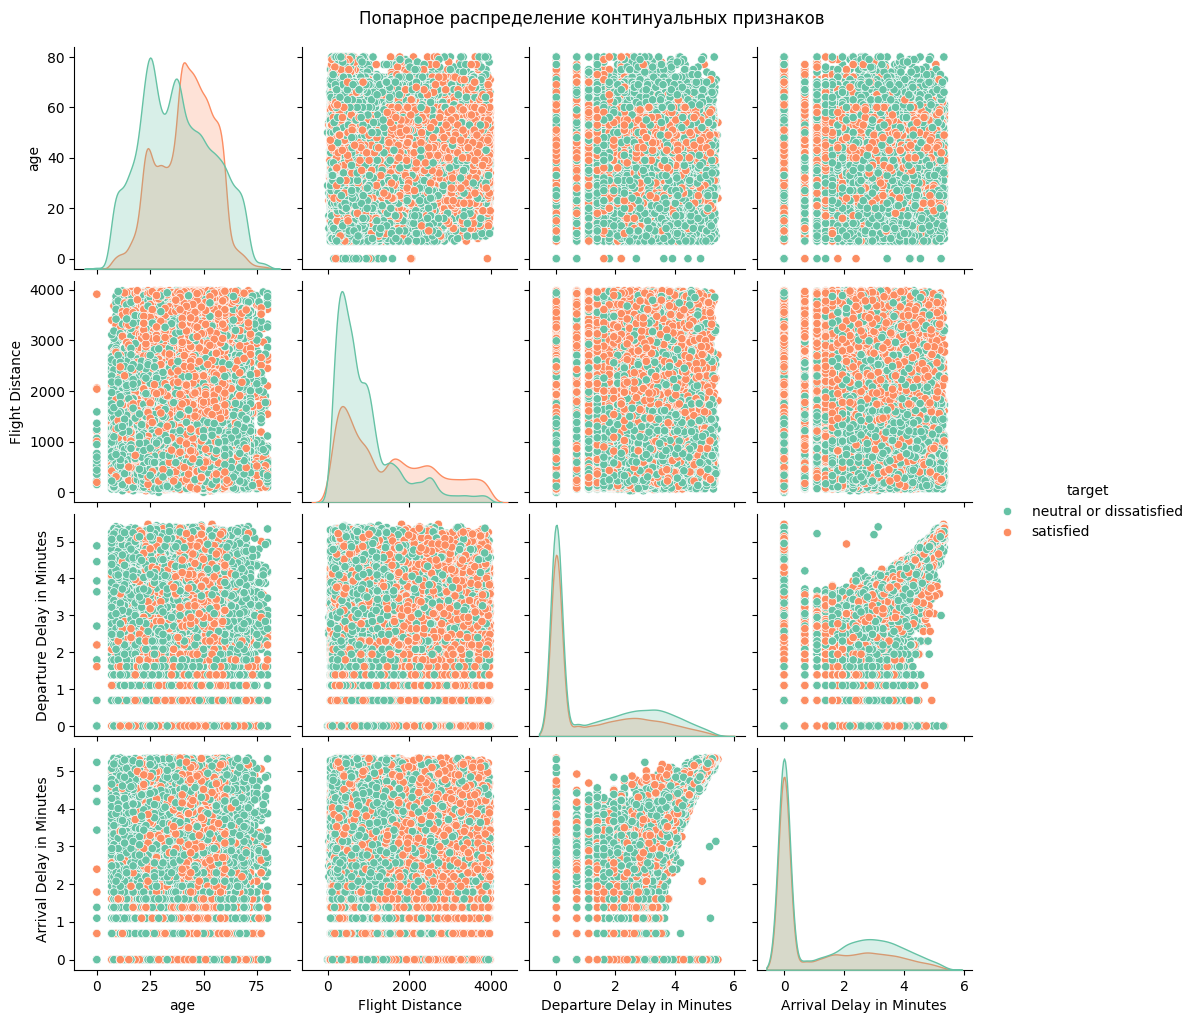

In [ ]:
X_train_with_target = X_train.copy()
X_train_with_target['target'] = y_train
sns.pairplot(X_train_with_target[continuous_cols + ['target']], diag_kind='kde', hue='target', palette='Set2')
plt.suptitle('Попарное распределение континуальных признаков', y=1.02)
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71175, 22), (71175,), (30498, 22), (30498,))

In [ ]:
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [ ]:
train_indices = X_train.index
val_indices = X_val.index

ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe.fit(X_train[categorical_cols])

X_train_ohe = pd.DataFrame(ohe.transform(X_train[categorical_cols]).toarray(),
                           columns=ohe.get_feature_names_out(input_features=categorical_cols))

X_val_ohe = pd.DataFrame(ohe.transform(X_val[categorical_cols]).toarray(),
                         columns=ohe.get_feature_names_out(input_features=categorical_cols))

X_train = X_train.drop(columns=categorical_cols).reset_index(drop=True)
X_val = X_val.drop(columns=categorical_cols).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_val = pd.concat([X_val, X_val_ohe], axis=1)

X_train.index = train_indices
X_val.index = val_indices

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71175, 23), (71175,), (30498, 23), (30498,))

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9434


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
from mlxtend.evaluate import bias_variance_decomp

error_dt, bias_dt, var_dt = bias_variance_decomp(
    dt_model, X_train.values, y_train.values, X_val.values, y_val.values, loss='0-1_loss')

error_dt, bias_dt, var_dt

(0.06193717620827595, 0.04000262312282773, 0.04608105449537675)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
# Вероятно модель переобучена из-за большой глубины дерева и varians error
tree_depth = dt_model.get_depth()
n_leaves = dt_model.get_n_leaves()

print(f"Глубина дерева: {tree_depth}")
print(f"Количество листьев: {n_leaves}")

Глубина дерева: 33
Количество листьев: 2084


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

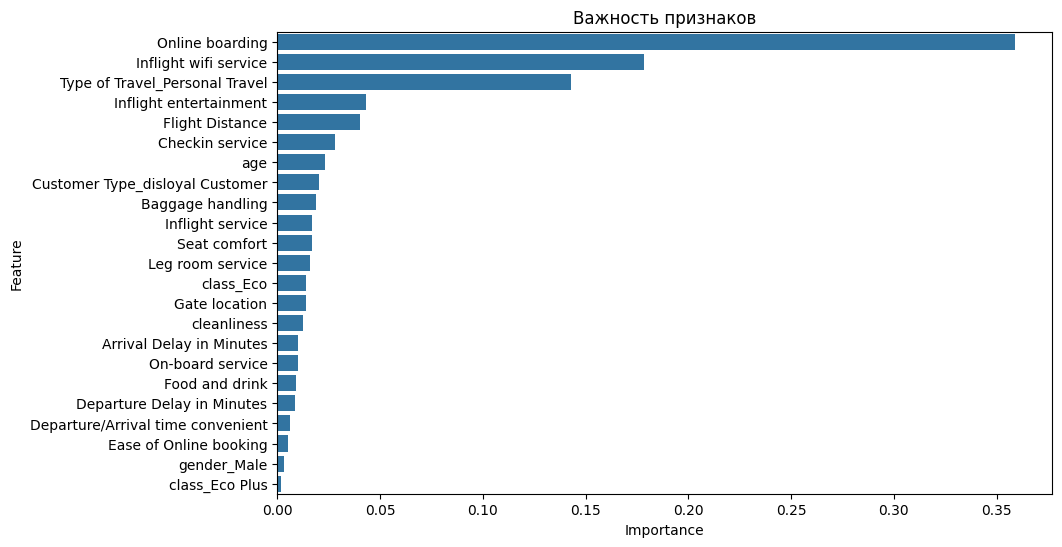

In [ ]:
importances = dt_model.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Важность признаков')
plt.show()

In [ ]:
# Топ 5 самыx важные признаки
importance_df.head()

Feature  Importance
9                  Online boarding    0.359009
4            Inflight wifi service    0.178367
20  Type of Travel_Personal Travel    0.142927
11          Inflight entertainment    0.043105
1                  Flight Distance    0.040264

Online boarding

Inflight wifi service

Type of Travel_Personal Travel

Inflight entertainment

Customer Type_disloyal Customer


### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
top_2_feature = ["Online boarding", "Inflight wifi service"]

X_train_top_2 = X_train[top_2_feature]

# Дерево решений с максимальной глубиной 5, используя только два признака
top_2_model = DecisionTreeClassifier(max_depth=5, random_state=42)
top_2_model.fit(X_train_top_2, y_train)

y_pred = top_2_model.predict(X_val[top_2_feature])

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8251


### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

Предикаты дробные потому, что в случае порядковых признаков, алгоритм может работать с дробными значениями для поиска лучшего разделения

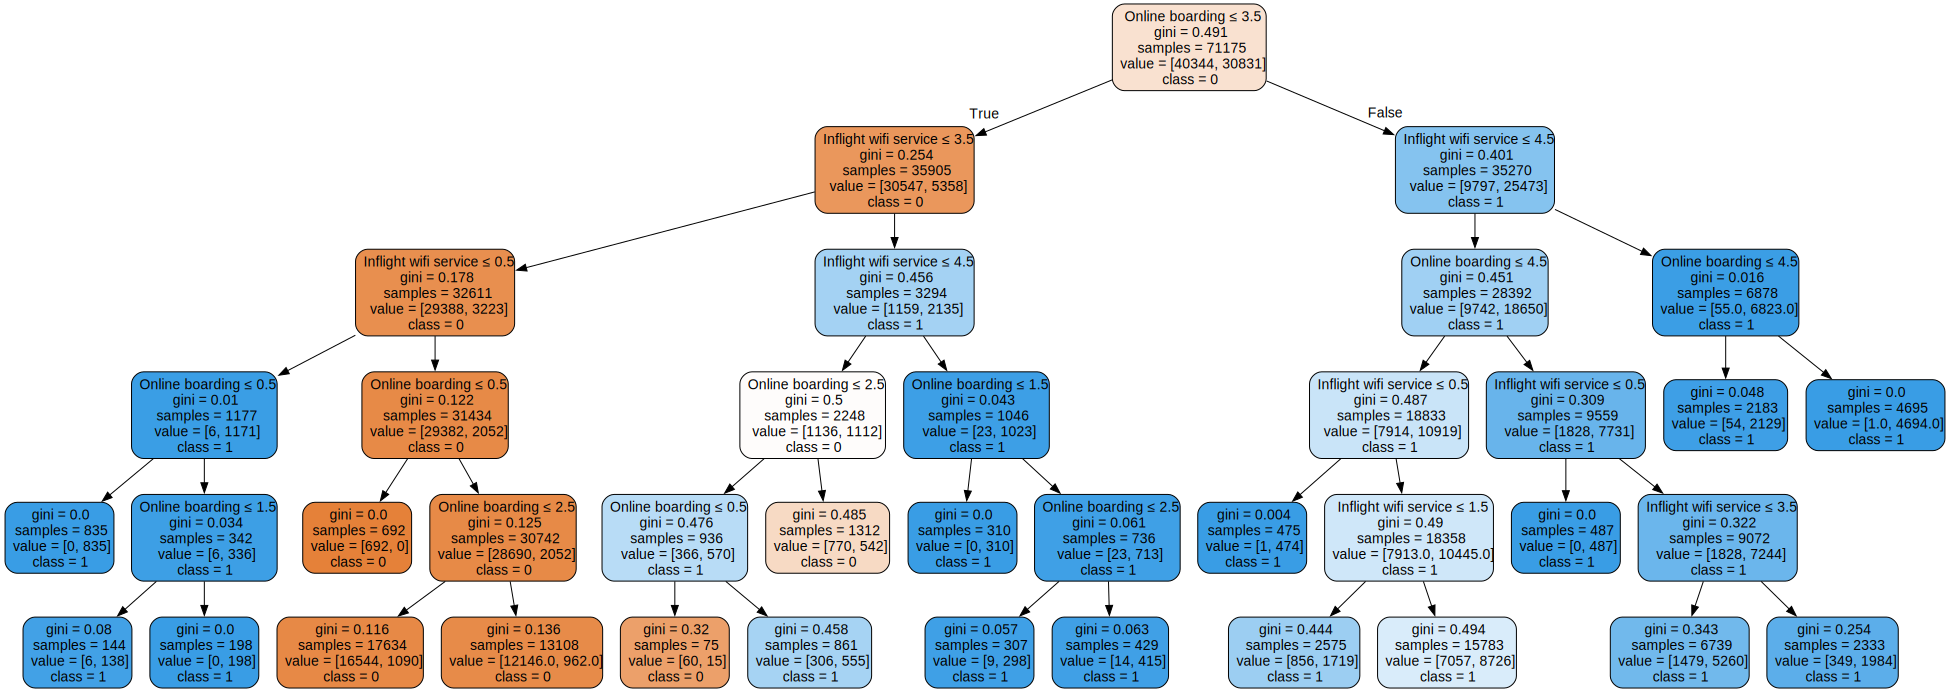

In [ ]:
# инфу брала отсюда: https://habr.com/ru/companies/nix/articles/426771/
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    top_2_model,
    out_file=None,
    feature_names=top_2_feature,
    class_names=top_2_model.classes_.astype(str),
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.render("decision_tree_top_2_features", format="png", cleanup=True)
graph


### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

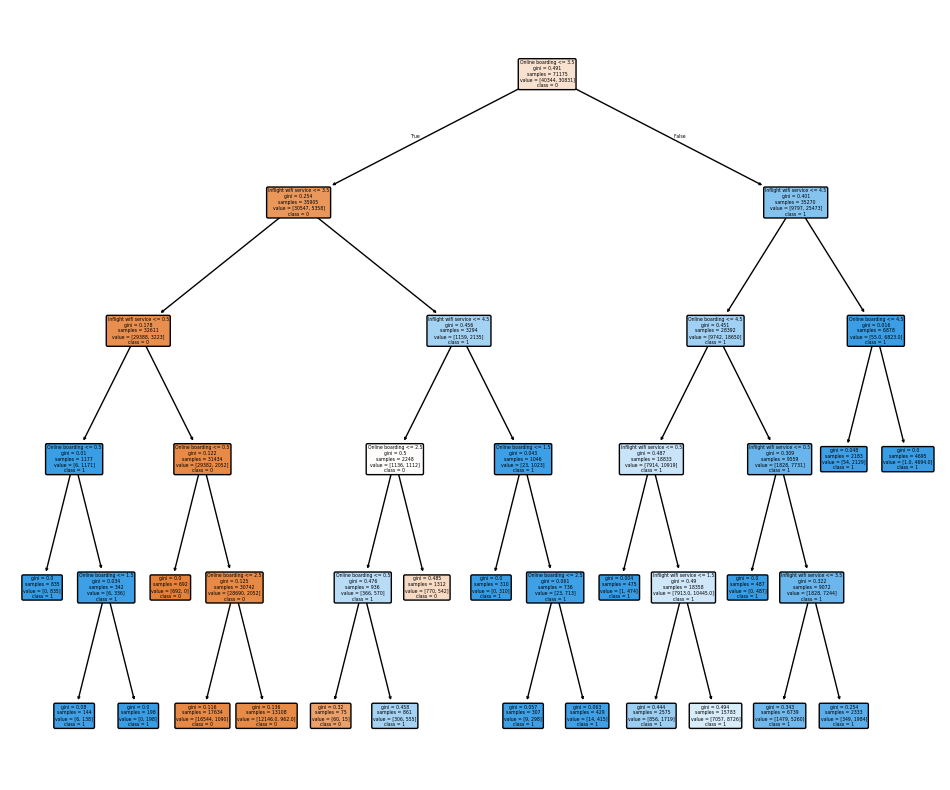

In [ ]:
# Дерево несимметричное, глубина относительно корня одинаковая, но количество узлов слева больше.
plt.figure(figsize=(12, 10))
plot_tree(top_2_model, filled=True, feature_names=top_2_feature, class_names=top_2_model.classes_.astype(str), rounded=True)
plt.show()

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

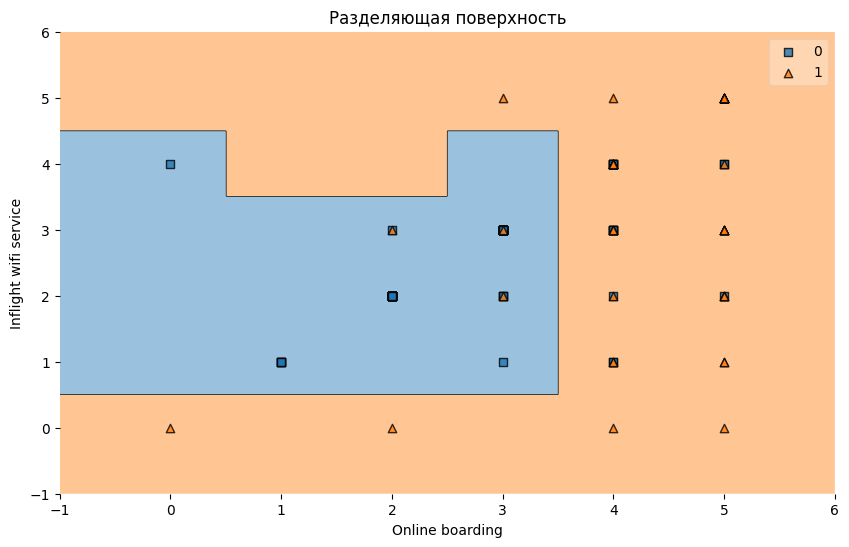

In [ ]:
X_train_top_2_subset = X_train_top_2[:100]
y_train_subset = y_train[:100]

plt.figure(figsize=(10, 6))

plot_decision_regions(X_train_top_2_subset.values, y_train_subset.values, clf=top_2_model, legend=1)

plt.title("Разделяющая поверхность")
plt.xlabel("Online boarding")
plt.ylabel("Inflight wifi service")
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

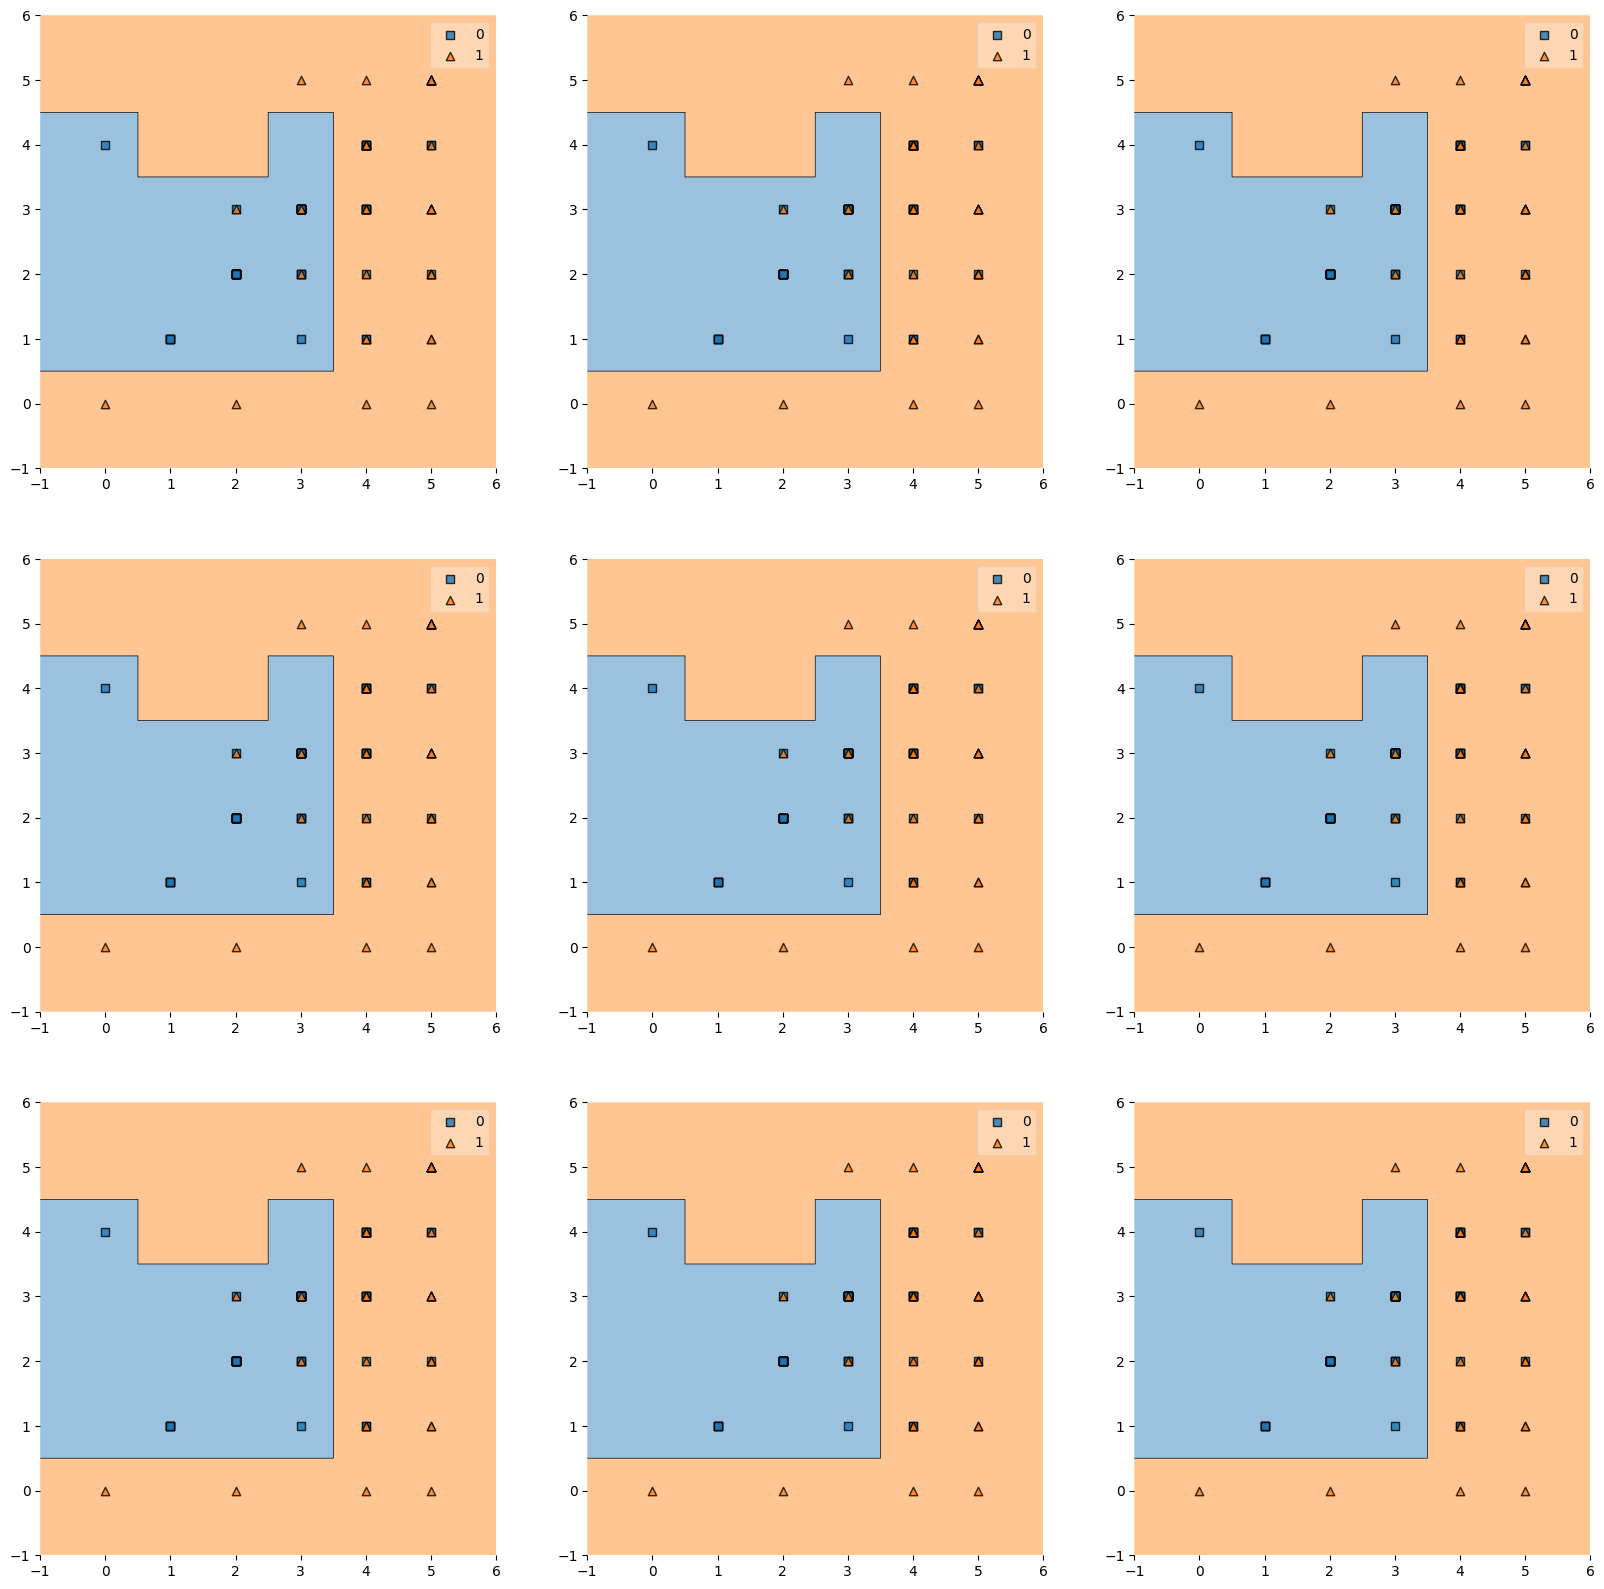

In [ ]:
# Доказать не получилось....
# замените X_train_example на вашу переменную
X_train_example = X_train[top_2_feature].copy()

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)
# Работаю в vs code, %%time не работает. Переписала код немного
import time
start_time = time.time()

depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

end_time = time.time()
print(f"Время выполнения: {end_time - start_time} секунд")

Время выполнения: 5.145244359970093 секунд


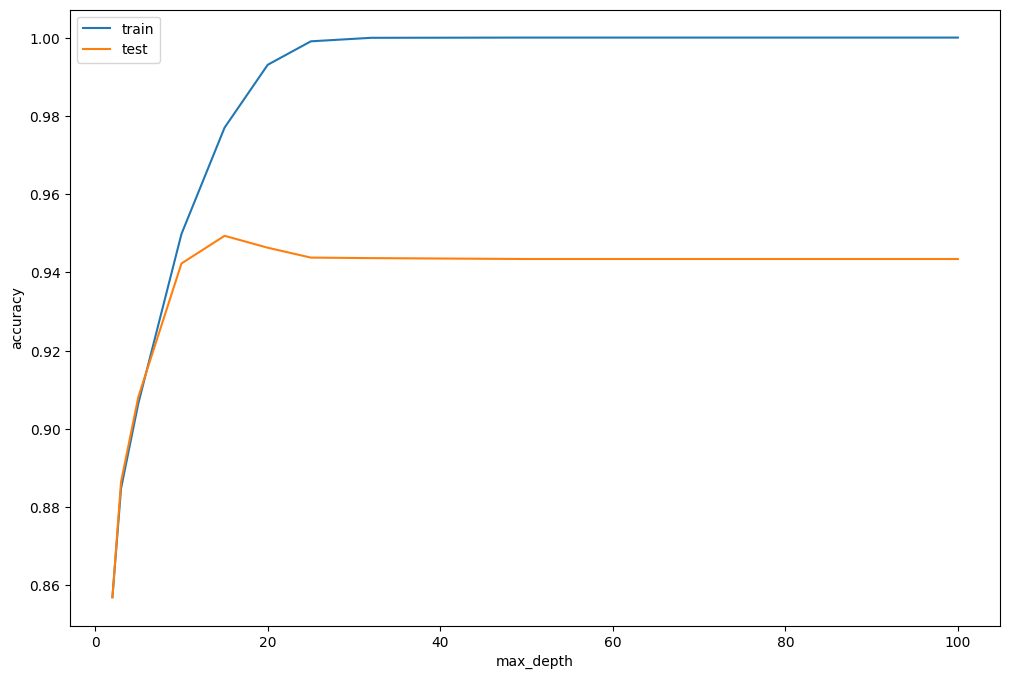

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 12),
    'max_features': ["auto", "sqrt", "log2"]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='accuracy')

In [ ]:
print("Best param:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Best param: {'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt'}
Accuracy: 0.9209


### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9610


### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

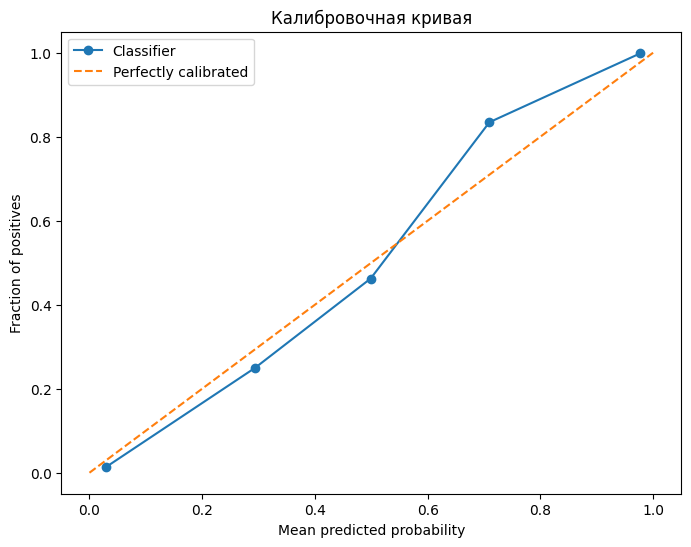

In [ ]:
from sklearn.calibration import calibration_curve

y_prob = rf_model.predict_proba(X_val)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, y_prob, n_bins=5)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label="Classifier")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly calibrated")
plt.title('Калибровочная кривая')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

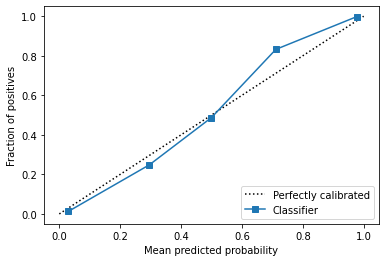

In [ ]:
# Ваш код здесь

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

Деревья могут давать вероятность в пределах от 0 до 1, но эти вероятности не всегда корректны с точки зрения статистики, поскольку они основываются на доле объектов в каждом листе, а не на глобальной модели вероятности. В деревьях у нас в области пространства буквально получается доля объектов положительного класса, т.е вероятность.

### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [ ]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8721


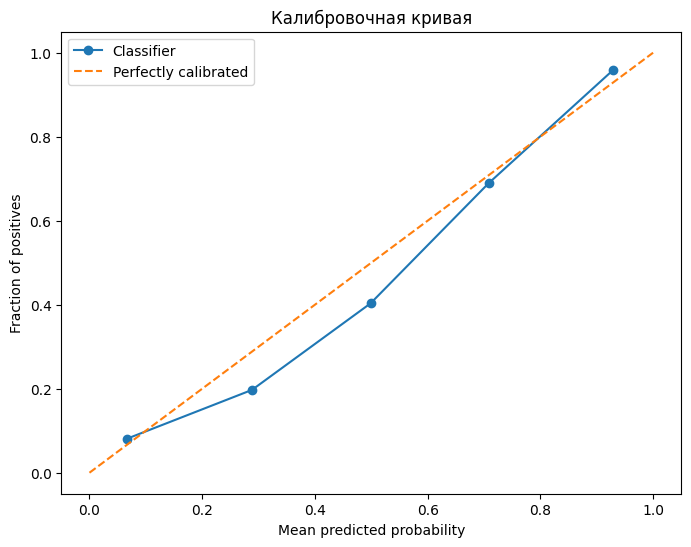

In [ ]:
y_prob = log_model.predict_proba(X_val)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_val, y_prob, n_bins=5)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label="Classifier")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly calibrated")
plt.title('Калибровочная кривая')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

CPU times: user 530 ms, sys: 278 ms, total: 808 ms
Wall time: 431 ms


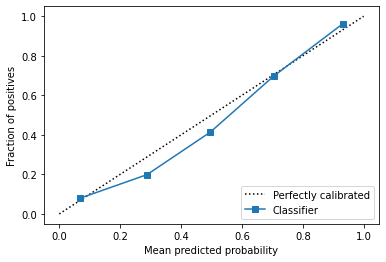

In [ ]:
# Ваш код здесь

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

Логистическая регрессия моделирует вероятность как сигмоидную функцию от линейной комбинации признаков, что позволяет получать корректные вероятности.
Логистическая регрессия буквально оптимизируем максимум правдоподобия, т.е вероятности.

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

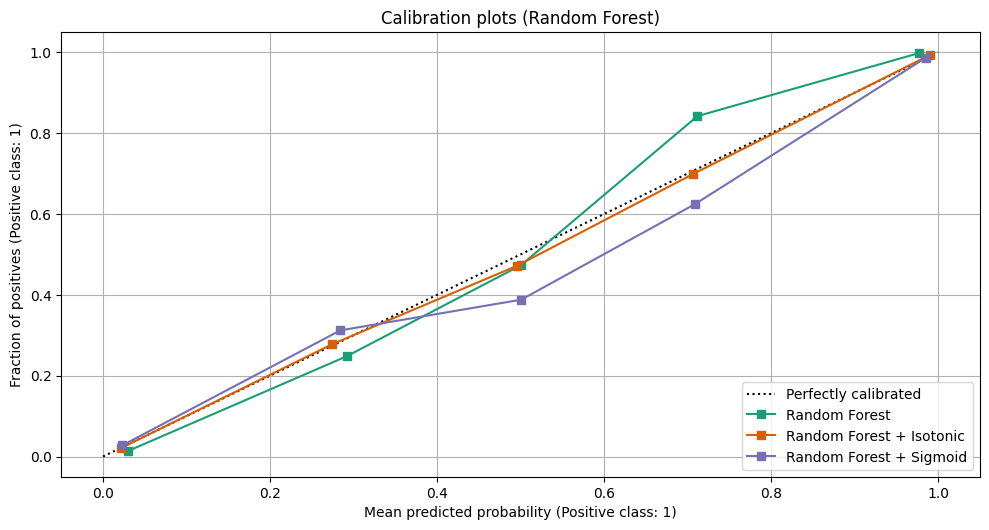

In [ ]:
# Код из лекции https://github.com/Murcha1990/ML_AI24/blob/main/Lesson11_SVM_Calibration/Calibration.ipynb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()

rf = RandomForestClassifier()
rf_isotonic = CalibratedClassifierCV(rf, cv=3, method="isotonic")
rf_sigmoid = CalibratedClassifierCV(rf, cv=3, method="sigmoid")

clf_list = [
    (rf, "Random Forest"),
    (rf_isotonic, "Random Forest + Isotonic"),
    (rf_sigmoid, "Random Forest + Sigmoid"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=5,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Random Forest)")

plt.tight_layout()
plt.show()

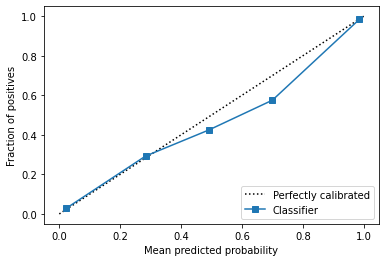

In [ ]:
# Ваш код здесь (Logreg)

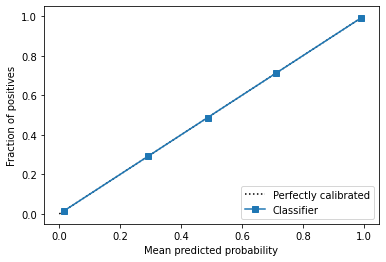

In [ ]:
# Ваш код здесь (isoreg)

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

• Метод Байесовского биннинга https://www.dbmi.pitt.edu/wp-content/uploads/2022/10/Obtaining-well-calibrated-probabilities-using-Bayesian-binning.pdf.
Суть метода заключается в том, чтобы разбить предсказанные вероятности на группы и применить сглаживание на основе апостериорную вероятность, рассчитанной по теореме Байеса.

• Temperature Scaling https://jamesmccaffrey.wordpress.com/2021/01/28/temperature-scaling-for-neural-network-calibration/ (я не знаю как это работает что-то из нейросетей)

### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71175, 23), (71175,), (30498, 23), (30498,))

In [ ]:
# Сделала на подвыборке 20к, иначе считает очень долго
from mlxtend.evaluate import bias_variance_decomp

X_train_20k = X_train[:20000]
y_train_20k = y_train[:20000]
X_val_20k = X_val[:20000]
y_val_20k = y_val[:20000]

error_dt, bias_dt, var_dt = bias_variance_decomp(
    rf_model, X_train_20k.values, y_train_20k.values, X_val_20k.values, y_val_20k.values, loss='0-1_loss')

error_dt, bias_dt, var_dt

(0.049613250000000005, 0.0471, 0.01214175)

У случайного леса разброс меньше, чем у дерева: случайный лес уменьшает вариативность за счет агрегации деревьев.

Ошибка у случайного леса меньше, что свидетельствует о его более стабильных и точных предсказаниях.

Смещение случайного леса выше, возможно потому что считалось не на всех данных или возможно суммарное смещение случайного леса может быть немного выше, чем у одиночного дерева, поскольку суммируются смещения нескольких деревьев (но это неточно).

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
# Сделала на подвыборке 20к, иначе считает очень долго
from mlxtend.evaluate import bias_variance_decomp

error_dt, bias_dt, var_dt = bias_variance_decomp(
    log_model, X_train_20k.values, y_train_20k.values, X_val_20k.values, y_val_20k.values, loss='0-1_loss')

error_dt, bias_dt, var_dt

(0.12871624999999998, 0.1273, 0.01468425)

Все три показателя у логистической регресии выше, чем у случайного леса.

Логистическая регрессия демонстрирует более высокие значения ошибки и смещения, что указывает на её недостаточную способность моделировать сложные зависимости в данных.

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
from scipy.stats import uniform

rf = RandomForestClassifier()

param_dist = {
    'max_depth': np.arange(2, 12),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_samples': uniform(0.1, 0.9)
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000248343B3E50>},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
print(f"Best params: {random_search.best_params_}")

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Best params: {'max_depth': 11, 'max_features': 'log2', 'max_samples': 0.5104629857953323}
Accuracy: 0.9466


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн
X_train_enc = X_train.copy()

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

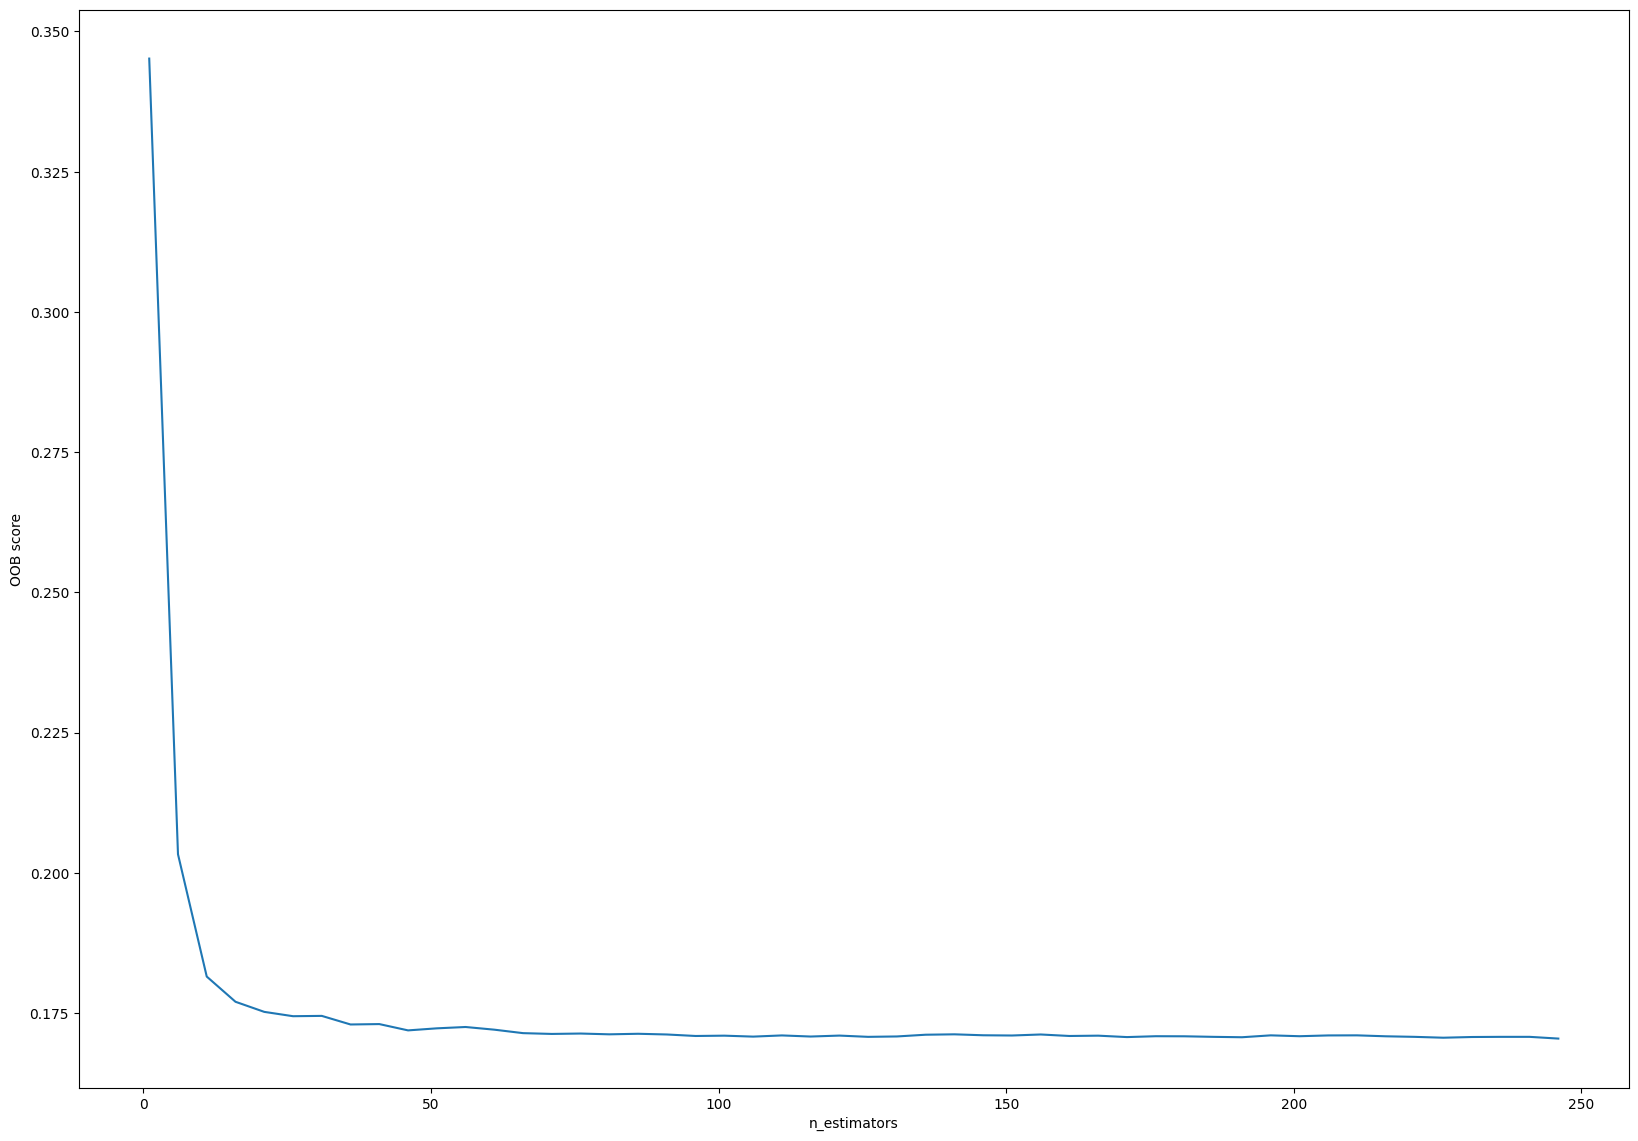

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


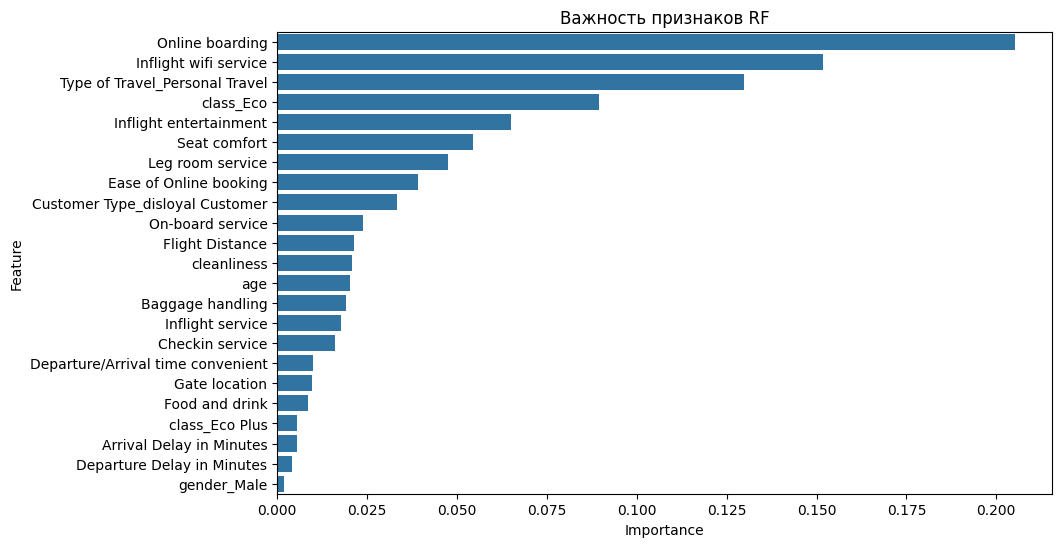

In [ ]:
rf_importance = best_rf.feature_importances_

features = X_train.columns
rf_importance_df = pd.DataFrame({'Feature': features, 'Importance': rf_importance})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df)
plt.title('Важность признаков RF')
plt.show()


In [ ]:
rf_importance_df.head()

Feature  Importance
9                  Online boarding    0.205269
4            Inflight wifi service    0.151880
20  Type of Travel_Personal Travel    0.129875
21                       class_Eco    0.089573
11          Inflight entertainment    0.065035

In [ ]:
importance_df.head()

Feature  Importance
9                  Online boarding    0.359009
4            Inflight wifi service    0.178367
20  Type of Travel_Personal Travel    0.142927
11          Inflight entertainment    0.043105
1                  Flight Distance    0.040264

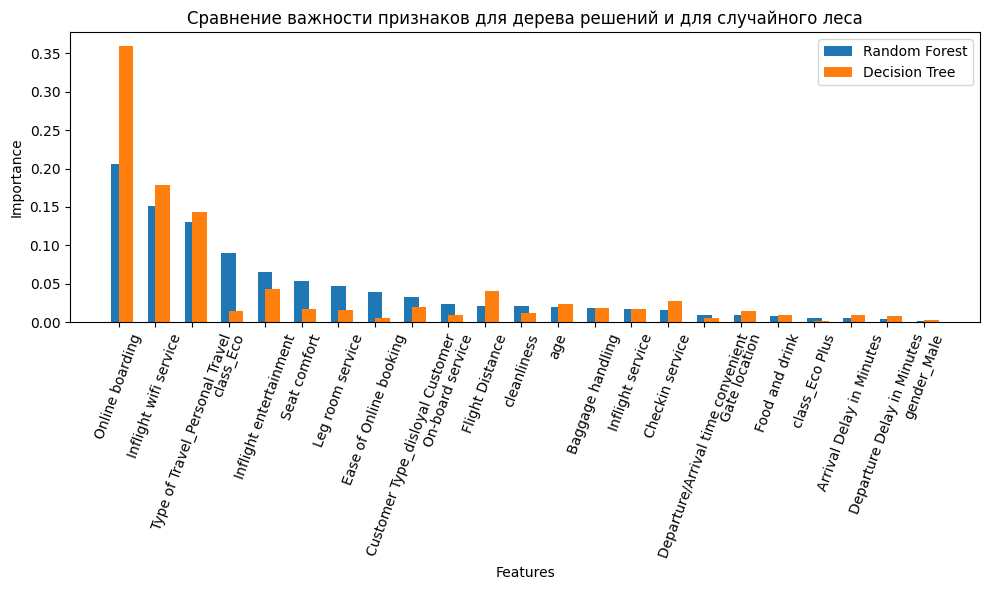

In [ ]:
comparison_df = pd.merge(rf_importance_df, importance_df, on='Feature', suffixes=('_rf', '_dt'))
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(comparison_df))

ax.bar(x, comparison_df['Importance_rf'], width=0.4, label='Random Forest', align='center')
ax.bar(x, comparison_df['Importance_dt'], width=0.4, label='Decision Tree', align='edge')

ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Сравнение важности признаков для дерева решений и для случайного леса')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Feature'], rotation=70)
ax.legend()

plt.tight_layout()
plt.show()

Топ 3 первых признака по важности одинаковые для двух моделей, в целом важность признаков схожа.

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [ ]:
# У меня лучший скор был без подбора параметров, но сохранила ту модель, что было через RandomizedSearchCV.
# Разница в скоре не большая, вероятно улучшить не удалось из-за ограничения по глубине
with open('RF.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
with open('RF.pkl', 'rb') as file:
    best_rf = pickle.load(file)

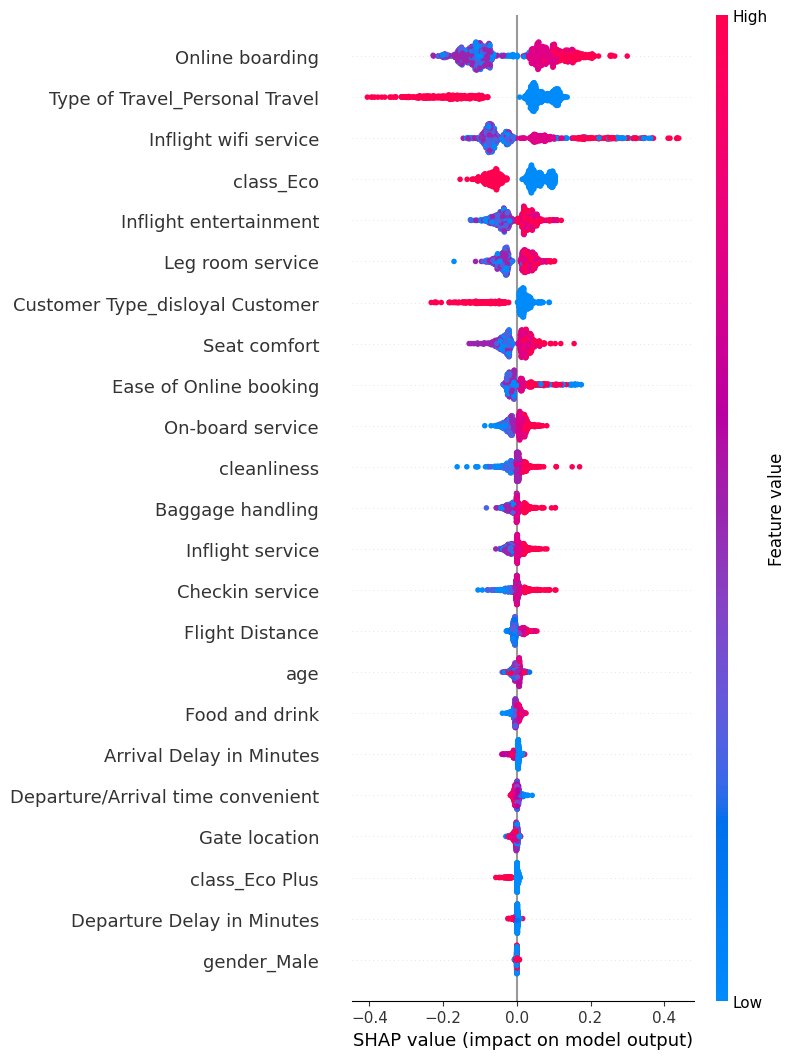

In [ ]:
# опиралась на: https://stackoverflow.com/questions/66018154/how-to-understand-shapley-value-for-binary-classification-problem
# На этот график ушло 4 часа....
from shap import TreeExplainer, summary_plot
sample_data = X_train.sample(n=1000)
exp = TreeExplainer(best_rf)
sv = exp.shap_values(sample_data)
shap_values_class_1 = sv[:, :, 1]
summary_plot(shap_values_class_1, sample_data, max_display=23)

Online boarding, Type of Travel_Personal travel, Inflight wifi service - топ 3 самых важных признака.

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

• dependence_plot, который показывает зависимость между значением признака и его влиянием на предсказание, а также помогает понять взаимодействие между признаками. Строится для каждого признака отдельно. На графиках по оси Х выводится значение признака, а по оси Y — значение SHAP для него.

• partial_dependence_plot - показывают незначительное влияние одного или двух признаков на прогнозируемый результат модели машинного обучения. Полезен для визуализации эффекта изменения одного признака при контролировании других.

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
from lime.lime_tabular import LimeTabularExplainer


explainer = lime.lime_tabular.LimeTabularExplainer(X_val.values, feature_names=X_val.columns.values.tolist(), mode='regression')
explanation = explainer.explain_instance(X_val.values[2], best_rf.predict, num_features=5)

explanation.show_in_notebook(show_table=True)

Type of Travel_Personal вносит положительный вклад в прогнозирование класса 1

Остальные переменные вносят негативный клад.

## Котобонус!

0.25 балла

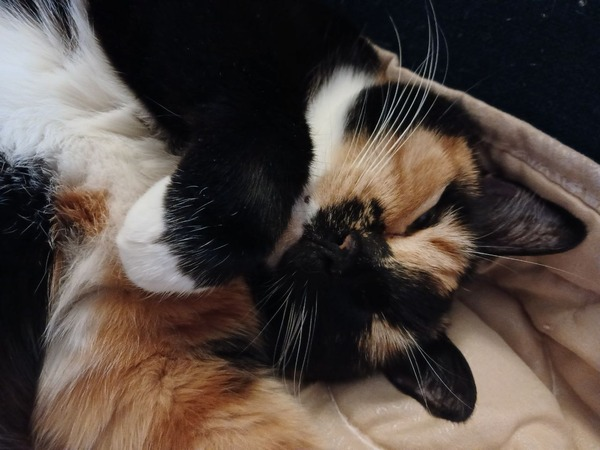

@sabrina_sadiekh

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Домашнее задание оказалось очень объёмным, на выполнение ушло минимум 40 часов (первые 15 пыталась засекать, потом просто устала).
Задание не очень хорошо структурировано, не совсем понятно, для чего в итоге нужен `df_test`. Многие задания ссылаются на предыдущие, а до них порой приходится пролистывать целые сотни ячеек, чтобы понять, о чём речь. Это создаёт ощущение, что либо всё задание нужно делать за один раз (что невозможно из-за объёма), либо каждый раз приходится возвращаться к предыдущим ячейкам, чтобы вспомнить, что ты делал.

Задание с визуализацией `shap` было, вероятно, самым сложным. В большинстве примеров в интернете для задачи регрессии, а для бинарной классификации было трудно адаптировать подход. В итоге это привело к трудности в понимании.